<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
      Financial Text Sentiment Analysis
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
    Faraz Doagooye Tehrani, Amir Parsa Safari, Hosna Shahheidari
<br>
<font color=0CBCDF size=4>
</div>

____

# PART ONE

---

# Part 1 — Data Preparation & Preprocessing

This section prepares the **Financial PhraseBank** dataset for a Transformer-based sentiment classifier.

**Goal:** load and merge the dataset files, explore label distribution, clean/prepare text + labels, split into train/validation, and build PyTorch `Dataset` + `DataLoader` objects using a **BERT tokenizer** (token IDs + attention masks).

---

## 1.1 Load & Merge Dataset

**What we do**
- Download / unzip the Financial PhraseBank dataset (ZIP).
- Read all text files inside the dataset directory.
- Merge the content into a single `DataFrame` with at least:
  - `sentence`: input text
  - `label`: sentiment label (`positive`, `negative`, `neutral`)
- Plot the class distribution.

**Why it matters**
- PhraseBank is provided as multiple files (different agreement levels).
- Having one unified `DataFrame` makes preprocessing and experiments reproducible.

**Expected output**
- A `DataFrame` containing all examples.
- A bar chart showing class counts (expect many Neutral samples).

---

## 1.2 Preprocess + Train/Validation Split

**What we do**
- Clean and normalize text (light preprocessing recommended).
- Convert labels from strings to integer indices:
  - `negative → 0`
  - `neutral → 1`
  - `positive → 2`
- Perform an **80/20** split into train/validation using a **stratified split** (preserving class ratio).

**Why it matters**
- Consistent label mapping avoids evaluation mistakes.
- Stratification is important because the dataset is imbalanced (Neutral dominates).

**Expected output**
- `train_df` and `val_df` with correct columns:
  - `sentence`, `label_idx`
  - optional: `weight` (agreement weight per sample)
- Verified split ratio and class distributions for both splits.

---

## 1.3 PyTorch Dataset + DataLoaders with BERT Tokenizer

**What we do**
- Implement `FinancialDataset` to return:
  - `input_ids`
  - `attention_mask`
  - `labels`
  - optional: `weights` (for agreement weighting)
- Create `DataLoader`s:
  - `train_loader`
  - `val_loader`
- Optionally handle class imbalance using:
  - `WeightedRandomSampler` for training (recommended for macro-F1)

**Why it matters**
- Tokenization converts text to fixed-length tensors that a Transformer can process.
- Attention masks ensure the model ignores padding tokens.

**Expected output**
- Working `train_loader` and `val_loader` that yield batches with:
  - `(batch_size, max_len)` for `input_ids` and `attention_mask`
  - `(batch_size,)` for `labels` (and `weights` if used)

---

## Notes & Common Pitfalls

- **Imbalance:** Neutral is often the majority → macro-F1 can drop if you don’t correct for it.
- **Tokenizer choice:** Using `bert-base-uncased` tokenizer is allowed (it’s a tokenizer, not a pretrained classifier).
- **Padding:** Always pass `attention_mask` and ignore PAD tokens in pooling/attention.
- **Reproducibility:** set a random seed before splitting/training.

---

✅ After finishing Part 1, we have:
- `train_loader`, `val_loader`
- `tokenizer`, `MAX_LEN`
- label mapping + (optional) agreement weights ready for training

<font color=FF8C00 size=6>
Attention </font>

Set the colab boolean in the cell below to True if you are using google colab.

In [1]:
colab = False

In [2]:
import zipfile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import BertTokenizer
import copy
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from sklearn.metrics import f1_score

In [3]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
if colab:
    zip_path = '/content/drive/MyDrive/data/FinancialPhraseBank-v1.0.zip'
    extract_path = '/content/financial_data/FinancialPhraseBank-v1.0/'
else:
    zip_path = 'FinancialPhraseBank-v1.0.zip'
    extract_path = 'financial_data/'

if not os.path.exists(extract_path):
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Files extracted successfully!")
    else:
        print(f"Error: {zip_path} not found! Please move the zip file to: {os.getcwd()}")

data_file_allagree = os.path.join(extract_path , 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt')
df_allagree = pd.read_csv(data_file_allagree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')

print(f"Data ready! Total rows of all agree: {len(df_allagree)}")
df_allagree.head()

Data ready! Total rows of all agree: 2264


sentence     label
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive

In [5]:
data_file_75agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt')
df_75agree = pd.read_csv(data_file_75agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_66agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_66Agree.txt')
df_66agree = pd.read_csv(data_file_66agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_50agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_50Agree.txt')
df_50agree = pd.read_csv(data_file_50agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')


set_all = set(df_allagree['sentence'])
set_75 = set(df_75agree['sentence'])
set_66 = set(df_66agree['sentence'])
set_50 = set(df_50agree['sentence'])

check_1 = set_all.issubset(set_75)
check_2 = set_75.issubset(set_66)
check_3 = set_66.issubset(set_50)

print(f"Is AllAgree inside 75Agree? {check_1}")
print(f"Is 75Agree inside 66Agree? {check_2}")
print(f"Is 66Agree inside 50Agree? {check_3}")

print(f"\nCounts:")
print(f"AllAgree: {len(set_all)}")
print(f"75Agree:  {len(set_75)}")
print(f"66Agree:  {len(set_66)}")
print(f"50Agree:  {len(set_50)}")

Is AllAgree inside 75Agree? True
Is 75Agree inside 66Agree? True
Is 66Agree inside 50Agree? True

Counts:
AllAgree: 2259
75Agree:  3448
66Agree:  4211
50Agree:  4838


In [6]:
df_final = df_50agree.copy()

def assign_weight(sentence):
    if sentence in set_all:
        return 1.3
    elif sentence in set_75:
        return 1.1
    elif sentence in set_66:
        return 1.0
    else:
        return 0.9

df_final['weight'] = df_final['sentence'].apply(assign_weight)

print(df_final['weight'].value_counts())

weight
1.3    2264
1.1    1190
1.0     765
0.9     627
Name: count, dtype: int64


<font color=3C99D size=5>
Conclusion: </font>

Since the set of 50 agree is the most general one we will train on that and based on how sure they are, we gave them a weight and then in the loss function, we included them with that weight.

In [7]:
df = df_final

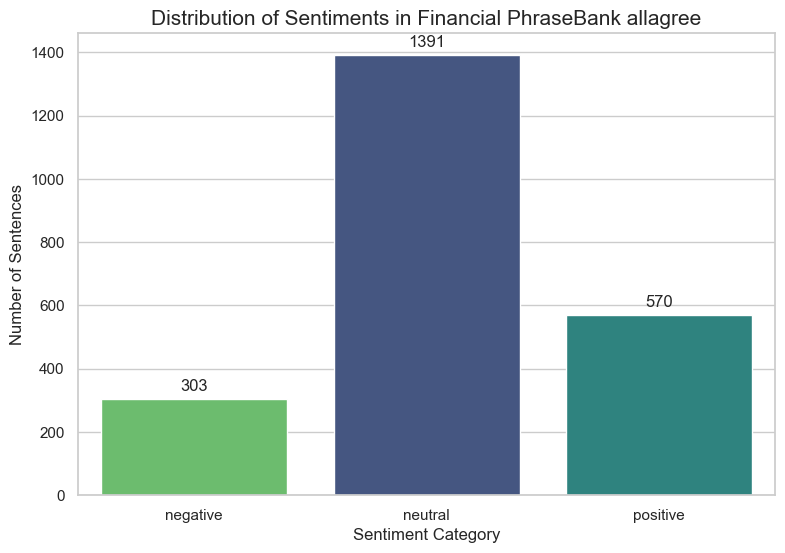

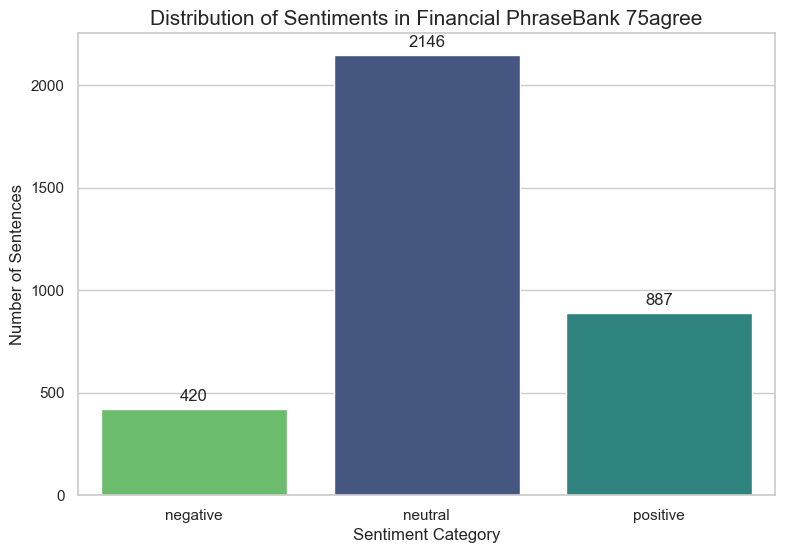

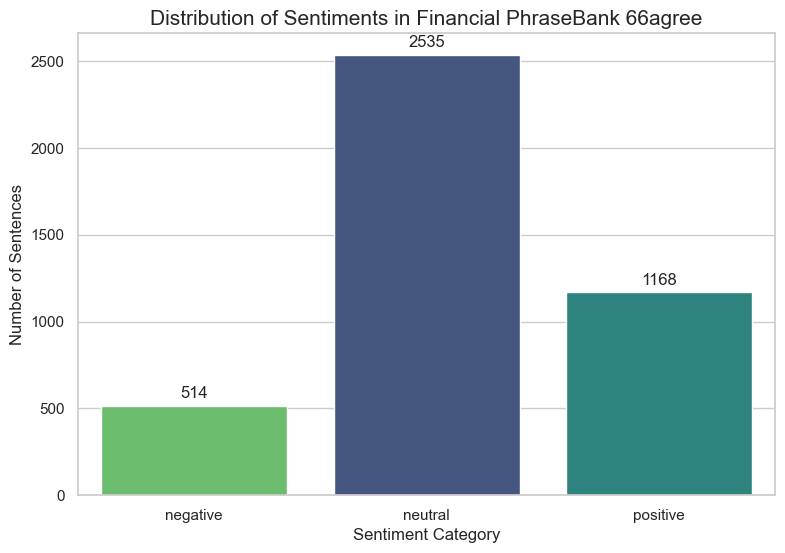

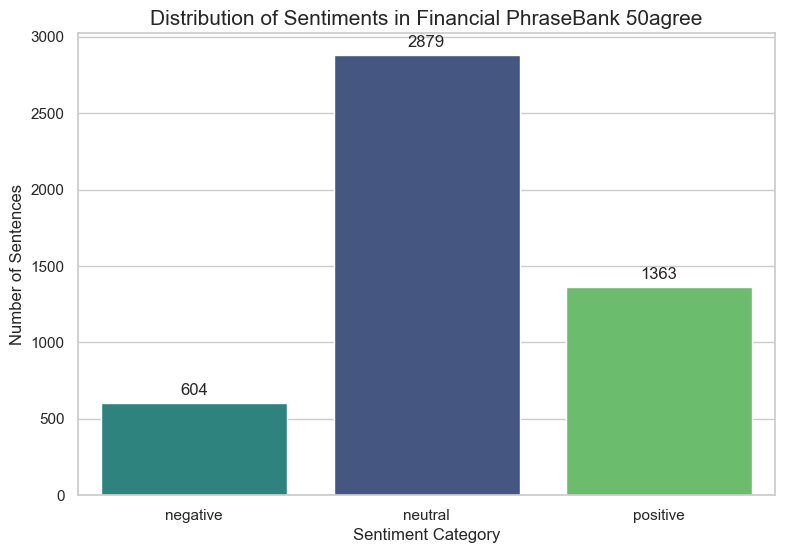

In [8]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_allagree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank allagree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_75agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 75agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_66agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 66agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_50agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 50agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

In [9]:
label_encoder = LabelEncoder() #turning labels to numbers
df['label_idx'] = label_encoder.fit_transform(df['label'])

class_names = label_encoder.classes_
print(f"Mapping: {dict(zip(range(len(class_names)), class_names))}")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_idx']
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train size: 3876, Validation size: 970


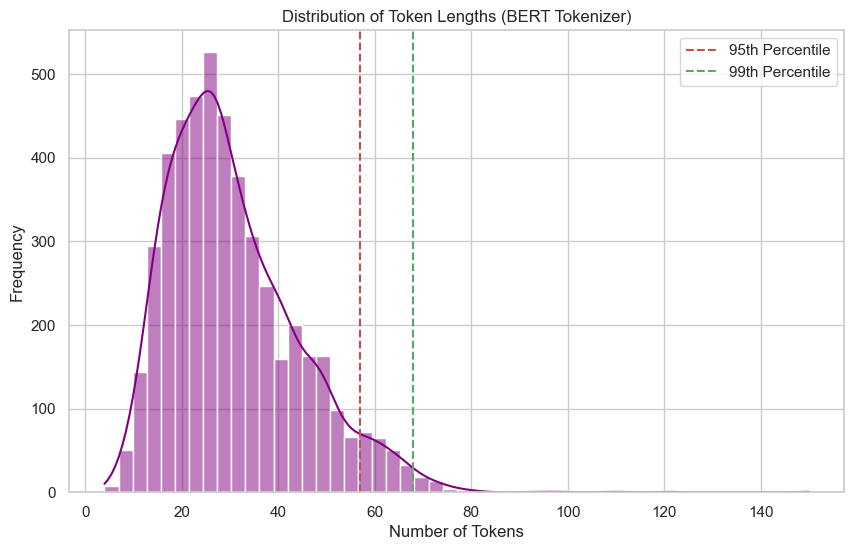

95% Percentile: 57.0
99% Percentile: 68.0
Max Length: 150


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df['token_lengths'] = [len(tokenizer.encode(s, add_special_tokens=True)) for s in df['sentence']]

plt.figure(figsize=(10, 6))
sns.histplot(df['token_lengths'], bins=50, kde=True, color='purple')
plt.title('Distribution of Token Lengths (BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.axvline(x=df['token_lengths'].quantile(0.95), color='r', linestyle='--', label='95th Percentile')
plt.axvline(x=df['token_lengths'].quantile(0.99), color='g', linestyle='--', label='99th Percentile')
plt.legend()
plt.show()

print(f"95% Percentile: {df['token_lengths'].quantile(0.95)}")
print(f"99% Percentile: {df['token_lengths'].quantile(0.99)}")
print(f"Max Length: {df['token_lengths'].max()}")

<font color=3C99D size=5>
Conclusion: </font>

Since only less than one percent of the sentences have more than 68 tokens, choosing 80 tokens as the max length is a good number



In [11]:
class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, weights, tokenizer, max_len=80):
        self.sentences = sentences.values
        self.labels = labels.values
        self.weights = weights.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        label = self.labels[item]
        weight = self.weights[item]

        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,  #Added [CLS], [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'weights': torch.tensor(weight, dtype=torch.float)
        }

In [ ]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# If you run the notebook top-to-bottom, MAX_LEN and use_weighted_sampler may not be defined yet.
# Use safe defaults here; later, if you change MAX_LEN, re-run this cell.
dataset_max_len = globals().get('MAX_LEN', 80)
use_weighted_sampler_local = globals().get('use_weighted_sampler', True)

train_dataset = FinancialDataset(train_df['sentence'], train_df['label_idx'], train_df['weight'], tokenizer, max_len=dataset_max_len)
val_dataset = FinancialDataset(val_df['sentence'], val_df['label_idx'], val_df['weight'], tokenizer, max_len=dataset_max_len)

BATCH_SIZE = 32

from torch.utils.data import WeightedRandomSampler

if use_weighted_sampler_local:
    class_counts = train_df['label_idx'].value_counts().sort_index()
    inv_freq = (1.0 / class_counts).to_dict()
    sample_weights = train_df['label_idx'].map(inv_freq).values.astype('float64')
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Train batches:', len(train_loader), 'Val batches:', len(val_loader), '| max_len:', dataset_max_len)


Train batches: 122 Val batches: 31 | max_len: 80


In [13]:

# Optional: trim padded sequences to the maximum *real* length in each batch.
# This keeps your Dataset unchanged (still pads to MAX_LEN), but reduces wasted computation
# and can slightly improve generalization on small datasets.
#
# Toggle with: use_batch_trimming (set in the config cell).

from torch.utils.data import DataLoader, WeightedRandomSampler

def trim_collate(batch):
    # batch: list[dict]
    input_ids = torch.stack([b["input_ids"] for b in batch], dim=0)
    attention_mask = torch.stack([b["attention_mask"] for b in batch], dim=0)
    labels = torch.stack([b["labels"] for b in batch], dim=0)
    weights = torch.stack([b["weights"] for b in batch], dim=0)

    # max number of non-pad tokens in this batch
    max_len = int(attention_mask.sum(dim=1).max().item())
    max_len = max(2, max_len)

    input_ids = input_ids[:, :max_len]
    attention_mask = attention_mask[:, :max_len]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "weights": weights,
    }

# Rebuild loaders with trim_collate if enabled
if globals().get("use_batch_trimming", False):
    use_weighted_sampler_local = globals().get('use_weighted_sampler', True)

    if use_weighted_sampler_local:
        class_counts = train_df['label_idx'].value_counts().sort_index()
        inv_freq = (1.0 / class_counts).to_dict()
        sample_weights = train_df['label_idx'].map(inv_freq).values.astype('float64')
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=trim_collate)
    else:
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=trim_collate)

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=trim_collate)
    print("Batch trimming enabled → loaders rebuilt with trim_collate().")
else:
    print("Batch trimming disabled → using original loaders.")


Batch trimming disabled → using original loaders.


# PART TWO

---

# Part 2 — Build the Transformer Model From Scratch

In this section we implement a **Transformer encoder** for 3-class financial sentiment classification **without using high-level ready-made Transformer modules** (e.g., no `nn.MultiheadAttention`, no pretrained BERT model classes).  
We implement the core building blocks manually using PyTorch tensor operations (`matmul`, `einsum`, masking, etc.).

**Goal:** create a complete model:
- token + positional embeddings
- stacked Transformer blocks (Self-Attention + FFN + Residuals + LayerNorm)
- final classifier head for **3 classes**: Negative, Neutral, Positive

---

## 2.1 Self-Attention

### What we implement
We implement a `SelfAttention` module that computes:

- Queries, Keys, Values:
\[
Q = XW_Q,\quad K = XW_K,\quad V = XW_V
\]

- Scaled dot-product attention:
\[
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]

### Multi-Head Attention
We split the model dimension into multiple heads:

- `d_model = num_heads * head_dim`
- Each head computes its own attention, then we concatenate and project back.

### Masking
We apply an **attention mask** so padding tokens do not influence attention scores:
- padded positions receive a large negative value before softmax (e.g., `-1e9`).

### Expected output
- A correct `(B, T, d_model)` output tensor.
- Optional: storing attention weights for visualization in Part 6.

---

## 2.2 Transformer Block (15 points)

A Transformer encoder block contains:

1) **Self-Attention sub-layer**
2) **Feed-Forward Network (FFN)**
3) **Residual connections**
4) **Layer normalization**
5) **Dropout**

### Pre-Norm architecture (recommended)
We use Pre-LayerNorm for stable training from scratch:

$
X = X + \text{Attention}(\text{LayerNorm}(X))
$
$
X = X + \text{FFN}(\text{LayerNorm}(X))
$

### Feed-Forward Network (FFN)
A standard FFN:
$
\text{FFN}(x) = W_2 \cdot \sigma(W_1 x + b_1) + b_2
$
with:
- hidden size = `ff_hidden_dim` (often `2x–4x d_model`)
- activation = **GELU** (common in Transformers)

### Expected output
- A reusable `TransformerBlock` module that preserves shape `(B, T, d_model)`.

---

## 2.3 Full Model: FinancialTransformer (15 points)

### Architecture overview
The full classifier model has:

1) **Token embedding**
2) **Positional embedding**
3) **Stack of Transformer blocks** (`NUM_LAYERS`)
4) **Pooling layer** to convert sequence → single vector
5) **Classifier head** producing logits of shape `(B, 3)`

### Embeddings
- Token embeddings convert IDs → vectors.
- Positional embeddings encode word order.

Optional but recommended:
- set `padding_idx` in embeddings so PAD tokens do not learn random embeddings.

### Pooling strategy
We convert `(B, T, d_model)` to `(B, d_model)` using one of:
- **Mean pooling (masked)** — often best when training from scratch
- **CLS pooling** — often better for pretrained models

### Classifier head
A small MLP or Linear layer mapping:
$
(B, d_model) \rightarrow (B, 3)
$

### Expected output
- A `FinancialTransformer` model that takes:
  - `input_ids`, `attention_mask`
- Outputs:
  - `logits` (for cross-entropy loss)
  - optionally attention weights (for Part 6)

---

## Notes & Common Pitfalls

- **Shape errors:** ensure reshaping across heads is correct.
- **Masking:** masks must broadcast correctly to attention score shape.
- **Head dimension:** `d_model % num_heads == 0` must hold.
- **Dropout:** apply to attention weights and/or FFN output to reduce overfitting.
- **Stability:** Pre-Norm blocks + gradient clipping typically train better from scratch.

---

After finishing Part 2, we have:
- `SelfAttention`
- `TransformerBlock`
- `FinancialTransformer` (end-to-end classifier)
- Model outputs of shape `(batch_size, 3)` ready for training in Part 3

In [ ]:
# Training configuration (tune these!)
dropout_val = 0.3
learning_rate = 2e-4          # peak LR (used by warmup/inv-sqrt schedule)
weight_decay = 0.01           # AdamW decoupled weight decay
epochs = 20 
warmup_ratio = 0.10           # 10% of total steps
grad_clip_norm = 1.0

# Imbalance + robustness options
use_weighted_sampler = True   # balances minibatches (recommended for macro-F1)
use_class_weights_in_loss = False  # usually keep False when sampler=True (avoid double-compensation)
use_agreement_weights = True  # uses df_final['weight'] (agreement-based) as per-example weights


# Advanced (no-pretraining) options to push Macro-F1
# - 'cb_focal' often improves minority-class recall (positive/negative) vs standard CE
# - R-Drop adds consistency regularization (2 forward passes with dropout)
loss_name = "cb_focal"        # options: "ce", "cb_focal"
cb_beta = 0.999               # class-balanced beta (close to 1.0)
focal_gamma = 2.0             # focal gamma (1.5–2.5 typical)

use_rdrop = True              # doubles forward passes; turn off if slow
rdrop_alpha = 2.0             # strength of KL consistency term (1–4 typical)

agreement_weight_power = 2.0  # >1 makes low-agreement examples contribute less (e.g., 50% -> 0.25)
use_batch_trimming = True     # trims padded length per-batch (faster; often slightly better)

label_smoothing = 0.05        # small smoothing helps with noisy labels (especially 50Agree)

# Pooling: 'mean' is often better than 'cls' when training from scratch
pooling = "mean"              # options: "mean", "cls"

# Model size (smaller than BERT is usually better from scratch on ~5k samples)
D_MODEL = 256                 # must be divisible by NUM_HEADS
NUM_HEADS = 4
NUM_LAYERS = 3
FF_HIDDEN_DIM = 4 * D_MODEL
MAX_LEN = 80
NUM_CLASSES = 3

print("Config ready.")


Config ready.


In [15]:
class MultiHeadAttention(nn.Module):
    # From-scratch multi-head self-attention (no nn.MultiheadAttention).
    # Supports:
    #   - padding mask (shape [B, S] or broadcastable to [B, 1, 1, S])
    #   - attention dropout
    #   - optional storing of last attention weights for visualization

    def __init__(self, d_model, num_heads, attn_dropout=0.1, store_attention=False):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=True)
        self.W_k = nn.Linear(d_model, d_model, bias=True)
        self.W_v = nn.Linear(d_model, d_model, bias=True)
        self.W_o = nn.Linear(d_model, d_model, bias=True)

        self.attn_dropout = nn.Dropout(attn_dropout)
        self.store_attention = store_attention
        self.last_attention_weights = None  # (B, H, S, S) when enabled

    def _shape(self, x, batch_size):
        # (B, S, D) -> (B, H, S, d_k)
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def forward(self, q, k, v, mask=None):
        # q,k,v: (B, S, D)
        # mask:
        #   - (B, S) attention_mask with 1 for tokens, 0 for padding
        #   - or (B, 1, 1, S) broadcastable mask
        batch_size, seq_len, _ = q.size()

        Q = self._shape(self.W_q(q), batch_size)
        K = self._shape(self.W_k(k), batch_size)
        V = self._shape(self.W_v(v), batch_size)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (B, H, S, S)

        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)  # (B, 1, 1, S)
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        if self.store_attention:
            self.last_attention_weights = attn_weights.detach()  # keep on device

        out = torch.matmul(attn_weights, V)  # (B, H, S, d_k)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (B, S, D)
        return self.W_o(out)


In [16]:
class TransformerBlock(nn.Module):
    # Encoder block with Pre-LayerNorm (more stable training from scratch).
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_model=d_model,
            num_heads=num_heads,
            attn_dropout=dropout,
            store_attention=False,
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_hidden_dim, d_model),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Pre-LN attention
        x_norm = self.norm1(x)
        attn_out = self.attention(x_norm, x_norm, x_norm, mask)
        x = x + self.dropout(attn_out)

        # Pre-LN FFN
        x_norm = self.norm2(x)
        ffn_out = self.ffn(x_norm)
        x = x + self.dropout(ffn_out)
        return x


In [17]:
class FinancialTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model,
        num_heads,
        num_layers,
        ff_hidden_dim,
        max_len,
        num_classes=3,
        dropout=0.1,
        pad_token_id=0,
        pooling="mean",
    ):
        super().__init__()
        self.d_model = d_model
        self.pooling = pooling
        self.pad_token_id = pad_token_id

        # padding_idx keeps the PAD embedding at zero and prevents it from updating
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)

        # Sinusoidal positional encoding (fixed)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("positional_encoding", pe.unsqueeze(0), persistent=False)

        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, num_heads, ff_hidden_dim, dropout) for _ in range(num_layers)]
        )

        self.final_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def set_store_attention(self, value: bool = True):
        # Enable/disable saving last-layer attention weights (for visualization)
        for layer in self.layers:
            layer.attention.store_attention = value

    def forward(self, input_ids, attention_mask):
        # input_ids: (B, S), attention_mask: (B, S)
        batch_size, seq_len = input_ids.shape

        # embedding scaling is standard for Transformers
        x = self.token_embedding(input_ids) * math.sqrt(self.d_model)
        x = x + self.positional_encoding[:, :seq_len, :]
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, attention_mask)

        x = self.final_norm(x)

        if self.pooling == "cls":
            pooled = x[:, 0, :]
        else:
            # masked mean pooling
            mask = attention_mask.unsqueeze(-1).float()  # (B, S, 1)
            summed = (x * mask).sum(dim=1)
            denom = mask.sum(dim=1).clamp(min=1e-6)
            pooled = summed / denom

        logits = self.classifier(pooled)
        return logits


In [18]:
VOCAB_SIZE = tokenizer.vocab_size
PAD_TOKEN_ID = tokenizer.pad_token_id

model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_hidden_dim=FF_HIDDEN_DIM,
    max_len=MAX_LEN,
    num_classes=NUM_CLASSES,
    dropout=dropout_val,
    pad_token_id=PAD_TOKEN_ID,
    pooling=pooling,
)

print(model)


FinancialTransformer(
  (token_embedding): Embedding(30522, 256, padding_idx=0)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (attn_dropout): Dropout(p=0.2, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (final_norm): LayerNorm((256,), eps=1e-05, el

# PART THREE

---

# Part 3 — Training the Model

In this section we train the `FinancialTransformer` model on the training split and monitor performance on the validation split.

**Goal:** implement a standard training pipeline using:
- optimizer (AdamW recommended)
- appropriate loss (CrossEntropy, optional label smoothing)
- logging of **loss** and **accuracy** for both Train and Validation each epoch
- checkpoint saving / loading and optional fine-tuning

---

## 3.1 Training Loop

### What we do
For each epoch:
1. Set model to `train()` mode.
2. For each minibatch:
   - Move tensors to `device`.
   - Forward pass to compute logits.
   - Compute the loss.
   - Backpropagation (`loss.backward()`).
   - Apply gradient clipping (optional but recommended).
   - Optimizer step.
   - Zero gradients.

### Loss function
We use multi-class cross entropy:

\[
\mathcal{L} = -\sum_{c=1}^{3} y_c \log p_c
\]

Optional improvements:
- **label smoothing** (helps with noisy labels in PhraseBank):
  - encourages less overconfident predictions

### Handling imbalance (recommended for macro-F1)
Because Neutral dominates, we typically apply at least one of:
- `WeightedRandomSampler` to rebalance batches
- class weights in the loss
- (optional) agreement weights if the dataset includes agreement level metadata

If we use agreement weights, we must compute per-sample losses:
- `CrossEntropyLoss(reduction="none")`
- then multiply each sample’s loss by its agreement weight before averaging

---

## 3.2 Monitoring: Loss & Accuracy Curves

### What we log
At the end of every epoch:
- `train_loss`, `train_accuracy`
- `val_loss`, `val_accuracy`

These are stored in a `history` dictionary so we can:
- plot learning curves
- diagnose underfitting vs overfitting
- track the best epoch

### Why accuracy is not enough
Because this is imbalanced, accuracy can look good even if the model ignores minority classes.  
Later in Part 4 we use macro/weighted metrics (Precision/Recall/F1) for a more reliable evaluation.

---

## Checkpointing

We save a checkpoint containing:
- `model_state_dict`
- `history`
- `epoch`
- training configuration (hyperparameters)

This allows:
- resuming training
- reproducing results
- running fine-tuning from the best weights

---

## Fine-tuning from a Loaded Checkpoint

After loading a checkpoint, we can continue training for a small number of epochs using:
- a **smaller learning rate** (e.g., `0.25 * original_lr`)
- the same preprocessing + model architecture

Fine-tuning is useful when:
- you found good hyperparameters
- the model is improving slowly
- you want to squeeze out extra macro-F1 without overfitting

---

## Notes & Common Pitfalls

- **Always call `model.train()` and `model.eval()`** in the right places.
- **Don’t forget `torch.no_grad()`** for validation to save memory and speed.
- **Use gradient clipping** to avoid exploding gradients in attention models.
- **Warmup + LR schedule** can stabilize training early when training from scratch.
- **Imbalance matters:** macro-F1 usually improves noticeably with balanced sampling.

---

After finishing Part 3, we have:
- a trained model
- training/validation curves (loss & accuracy)
- a saved checkpoint
- ability to load checkpoint and fine-tune if desired

## Extra options to improve Macro-F1 (no pretraining)

If you are stuck around **0.68–0.70 macro-F1**, the biggest gains usually come from **changing the objective** and **regularizing** for small / noisy data:

- **CB-Focal loss** (`loss_name="cb_focal"`): improves minority-class recall (Positive/Negative) on imbalanced data.
- **R-Drop** (`use_rdrop=True`): runs the model twice with dropout and adds a consistency (KL) penalty.
- **Agreement sharpening** (`agreement_weight_power>1`): makes low-agreement examples contribute less.
- **Batch trimming** (`use_batch_trimming=True`): trims padded length per batch (faster, sometimes slightly better).

All of these are implemented in this notebook without using pretrained embeddings/models.


In [19]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device set to: Apple MPS (GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Device set to: NVIDIA CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("Device set to: CPU")

if colab:
      path = '/content/drive/MyDrive/data/checkpoint.pth'
else:
      path = 'checkpoint.pth'

model.to(device)


Device set to: Apple MPS (GPU)


FinancialTransformer(
  (token_embedding): Embedding(30522, 256, padding_idx=0)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (attn_dropout): Dropout(p=0.2, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (final_norm): LayerNorm((256,), eps=1e-05, el

In [20]:
# Loss function
# - reduction='none' is required for correct per-example weighting
# - label_smoothing can help on noisy labels
#
# Note: if you enable sampler balancing, usually keep use_class_weights_in_loss=False.

if use_class_weights_in_loss:
    labels = train_df['label_idx'].values
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    reduction='none',
    label_smoothing=label_smoothing
)


In [21]:
# -------------------------------
# Advanced (no-pretraining) tricks
# 1) Class-Balanced Focal Loss (CB-Focal)  → improves minority recall → higher macro-F1
# 2) R-Drop regularization               → consistency regularization for small/noisy datasets
# 3) Sharpen agreement weights           → reduce influence of ambiguous (low-agreement) labels
# -------------------------------

import torch.nn.functional as F

class CBFocalLoss(nn.Module):
    """
    Class-Balanced Focal Loss for multi-class classification.
    alpha is computed from class counts using 'effective number of samples':
        alpha_c ∝ (1 - beta) / (1 - beta^{n_c})
    """
    def __init__(self, class_counts, beta=0.999, gamma=2.0, reduction="none"):
        super().__init__()
        counts = torch.tensor(class_counts, dtype=torch.float)

        beta_t = torch.tensor(beta, dtype=torch.float)
        effective_num = 1.0 - torch.pow(beta_t, counts)
        alpha = (1.0 - beta_t) / (effective_num + 1e-12)

        # Normalize so sum(alpha) == num_classes
        alpha = alpha / alpha.sum() * len(class_counts)
        self.register_buffer("alpha", alpha)
        self.gamma = float(gamma)
        self.reduction = reduction

    def forward(self, logits, targets):
        # logits: (B,C), targets: (B,)
        log_probs = F.log_softmax(logits, dim=-1)
        probs = torch.exp(log_probs)

        targets = targets.long()
        idx = torch.arange(logits.size(0), device=logits.device)
        pt = probs[idx, targets]
        log_pt = log_probs[idx, targets]

        at = self.alpha[targets]
        loss = -at * ((1.0 - pt) ** self.gamma) * log_pt  # (B,)

        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss  # "none"

# Instantiate CB-Focal loss using train distribution
_class_counts = train_df["label_idx"].value_counts().sort_index().tolist()
criterion_cb_focal = CBFocalLoss(_class_counts, beta=cb_beta, gamma=focal_gamma, reduction="none").to(device)

def compute_per_sample_loss(logits, labels):
    """
    Returns per-sample loss vector (B,).
    loss_name:
      - "ce": uses CrossEntropyLoss (with optional class weights + label smoothing)
      - "cb_focal": uses class-balanced focal loss
    """
    name = globals().get("loss_name", "ce")
    if name == "cb_focal":
        # When using CB-Focal, avoid also using class-weights in CE (double compensation).
        return criterion_cb_focal(logits, labels)
    return criterion(logits, labels)  # criterion is CE with reduction='none'

def symmetric_kl(logits1, logits2):
    """
    Symmetric KL divergence between two categorical distributions (per sample).
    Returns shape (B,).
    """
    p1 = F.log_softmax(logits1, dim=-1)
    p2 = F.log_softmax(logits2, dim=-1)

    kl12 = F.kl_div(p1, p2.exp(), reduction="none").sum(dim=-1)
    kl21 = F.kl_div(p2, p1.exp(), reduction="none").sum(dim=-1)
    return 0.5 * (kl12 + kl21)


<font color=DC143C size=6>
Warning </font>

Only set the train boolean in the cell below to True if you want to train and else set it to False.

In [22]:
train = False

In [23]:
from sklearn.metrics import f1_score

def evaluate_model(model, data_loader):
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_items = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            losses = compute_per_sample_loss(logits, labels)  # (B,)
            loss = losses.mean()

            total_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)

            total_correct += (preds == labels).sum().item()
            total_items += labels.size(0)

            all_preds.extend(preds.detach().cpu().tolist())
            all_labels.extend(labels.detach().cpu().tolist())

    avg_loss = total_loss / max(1, total_items)
    avg_acc = total_correct / max(1, total_items)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, avg_acc, macro_f1


In [24]:
from tqdm.auto import tqdm

def build_optimizer_and_scheduler(model, train_loader, epochs):
    # AdamW with decoupled weight decay; don't decay bias/LayerNorm weights
    no_decay = ('bias', 'LayerNorm.weight', 'LayerNorm.bias', 'norm1', 'norm2', 'final_norm')

    decay_params, nodecay_params = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if any(nd in n for nd in no_decay):
            nodecay_params.append(p)
        else:
            decay_params.append(p)

    optimizer = torch.optim.AdamW(
        [{'params': decay_params, 'weight_decay': weight_decay},
         {'params': nodecay_params, 'weight_decay': 0.0}],
        lr=learning_rate,
        betas=(0.9, 0.98),
        eps=1e-9
    )

    total_steps = epochs * len(train_loader)
    warmup_steps = max(1, int(warmup_ratio * total_steps))

    # Warmup + inverse-sqrt decay
    def lr_lambda(step):
        step = max(1, step)
        if step <= warmup_steps:
            return step / warmup_steps
        return (warmup_steps ** 0.5) / (step ** 0.5)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    return optimizer, scheduler

def train_model(model, train_loader, val_loader, epochs=epochs):
    model.to(device)

    optimizer, scheduler = build_optimizer_and_scheduler(model, train_loader, epochs)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_macro_f1': [],
        'lr': [],
    }

    best_val_f1 = -1.0
    best_model_wts = copy.deepcopy(model.state_dict())

    patience = 5
    patience_counter = 0
    global_step = 0

    for epoch in range(epochs):
        model.train()
        model.set_store_attention(False)

        running_loss = 0.0
        running_correct = 0
        running_items = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            if use_agreement_weights:
                w = batch['weights'].to(device).float()

                # Normalize to mean=1, then optionally sharpen (power>1 reduces low-agreement influence)
                w = w / w.mean().clamp(min=1e-6)
                power = float(globals().get('agreement_weight_power', 1.0))
                if power != 1.0:
                    w = w.clamp(min=0.0).pow(power)
                    w = w / w.mean().clamp(min=1e-6)
            else:
                w = None

            optimizer.zero_grad(set_to_none=True)

            # Forward + loss (supports CE / CB-Focal + optional R-Drop)
            if globals().get('use_rdrop', False):
                logits1 = model(input_ids, attention_mask)
                logits2 = model(input_ids, attention_mask)

                loss1 = compute_per_sample_loss(logits1, labels)
                loss2 = compute_per_sample_loss(logits2, labels)
                base = 0.5 * (loss1 + loss2)

                kl = symmetric_kl(logits1, logits2)  # (B,)
                alpha = float(globals().get('rdrop_alpha', 2.0))
                per_sample_losses = base + alpha * kl

                # Use averaged logits for accuracy tracking
                logits = 0.5 * (logits1 + logits2)
            else:
                logits = model(input_ids, attention_mask)
                per_sample_losses = compute_per_sample_loss(logits, labels)  # (B,)

            loss = (per_sample_losses * w).mean() if w is not None else per_sample_losses.mean()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
            optimizer.step()

            global_step += 1
            scheduler.step()
            history['lr'].append(optimizer.param_groups[0]['lr'])

            running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            running_correct += (preds == labels).sum().item()
            running_items += labels.size(0)

            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

        train_loss = running_loss / max(1, running_items)
        train_acc = running_correct / max(1, running_items)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc, val_f1 = evaluate_model(model, val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_macro_f1'].append(val_f1)

        print(
            f'Epoch {epoch+1}/{epochs} | '
            f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | '
            f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | '
            f'Val Macro-F1: {val_f1:.4f}'
        )

        if val_f1 > best_val_f1 + 1e-4:
            best_val_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping: no improvement in Macro-F1 for {patience} epochs.')
                break

    model.load_state_dict(best_model_wts)
    return history


In [25]:
def plot_results(history):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(list(epochs_range), history['train_loss'], label='Train Loss')
    plt.plot(list(epochs_range), history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(epochs_range), history['train_acc'], label='Train Acc')
    plt.plot(list(epochs_range), history['val_acc'], label='Val Acc')
    plt.plot(list(epochs_range), history['val_macro_f1'], label='Val Macro-F1')
    plt.title('Accuracy / Macro-F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


<font color=DC143C size=6>
Warning </font>

Only set the hyperparameter_tuning boolean in the cell below to True if you want to tune the hyperparameters.

In [ ]:
# Optional: hyperparameter tuning (disabled by default)
hyperparameter_tuning = False

tune_epochs = 10



Training with d_model = 128


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4617 Acc: 0.3457 | Val Loss: 0.4357 Acc: 0.1443 | Val Macro-F1: 0.1147


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.4197 Acc: 0.3811 | Val Loss: 0.4114 Acc: 0.3041 | Val Macro-F1: 0.2937


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.3692 Acc: 0.4974 | Val Loss: 0.3602 Acc: 0.4691 | Val Macro-F1: 0.4137


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.3307 Acc: 0.5725 | Val Loss: 0.3197 Acc: 0.5649 | Val Macro-F1: 0.5080


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.2976 Acc: 0.6300 | Val Loss: 0.3026 Acc: 0.5938 | Val Macro-F1: 0.5607


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.2738 Acc: 0.6785 | Val Loss: 0.2870 Acc: 0.6330 | Val Macro-F1: 0.5959


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.2511 Acc: 0.6984 | Val Loss: 0.2969 Acc: 0.6144 | Val Macro-F1: 0.5813


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.2304 Acc: 0.7265 | Val Loss: 0.2872 Acc: 0.6072 | Val Macro-F1: 0.5833


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.2236 Acc: 0.7402 | Val Loss: 0.2865 Acc: 0.6216 | Val Macro-F1: 0.5875


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2209 Acc: 0.7513 | Val Loss: 0.2934 Acc: 0.5918 | Val Macro-F1: 0.5796


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2045 Acc: 0.7567 | Val Loss: 0.2726 Acc: 0.6258 | Val Macro-F1: 0.5937
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with d_model = 256


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4602 Acc: 0.3439 | Val Loss: 0.4474 Acc: 0.1299 | Val Macro-F1: 0.0821


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3891 Acc: 0.4489 | Val Loss: 0.3826 Acc: 0.4351 | Val Macro-F1: 0.4106


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.3252 Acc: 0.5753 | Val Loss: 0.3535 Acc: 0.5031 | Val Macro-F1: 0.4579


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.2666 Acc: 0.6685 | Val Loss: 0.3182 Acc: 0.5680 | Val Macro-F1: 0.5464


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.2252 Acc: 0.7374 | Val Loss: 0.2944 Acc: 0.6165 | Val Macro-F1: 0.5628


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.2030 Acc: 0.7621 | Val Loss: 0.2789 Acc: 0.6567 | Val Macro-F1: 0.6292


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.1853 Acc: 0.7869 | Val Loss: 0.2980 Acc: 0.6381 | Val Macro-F1: 0.6053


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.1642 Acc: 0.8119 | Val Loss: 0.2934 Acc: 0.6608 | Val Macro-F1: 0.6221


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.1479 Acc: 0.8261 | Val Loss: 0.3120 Acc: 0.6557 | Val Macro-F1: 0.6277


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.1329 Acc: 0.8460 | Val Loss: 0.3019 Acc: 0.6784 | Val Macro-F1: 0.6416


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.1221 Acc: 0.8493 | Val Loss: 0.3163 Acc: 0.7000 | Val Macro-F1: 0.6495


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.1109 Acc: 0.8648 | Val Loss: 0.3477 Acc: 0.6289 | Val Macro-F1: 0.6144


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.1053 Acc: 0.8687 | Val Loss: 0.3500 Acc: 0.6567 | Val Macro-F1: 0.6339


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0977 Acc: 0.8723 | Val Loss: 0.3517 Acc: 0.6753 | Val Macro-F1: 0.6481


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0989 Acc: 0.8860 | Val Loss: 0.3522 Acc: 0.6680 | Val Macro-F1: 0.6464


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0929 Acc: 0.8865 | Val Loss: 0.3646 Acc: 0.6763 | Val Macro-F1: 0.6526


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0884 Acc: 0.8878 | Val Loss: 0.3671 Acc: 0.6897 | Val Macro-F1: 0.6646


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0848 Acc: 0.8981 | Val Loss: 0.3765 Acc: 0.7072 | Val Macro-F1: 0.6687


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0804 Acc: 0.8945 | Val Loss: 0.3992 Acc: 0.7031 | Val Macro-F1: 0.6674


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0745 Acc: 0.9053 | Val Loss: 0.4020 Acc: 0.7134 | Val Macro-F1: 0.6757

Training with d_model = 512


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4482 Acc: 0.3540 | Val Loss: 0.3990 Acc: 0.2959 | Val Macro-F1: 0.2555


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3441 Acc: 0.5253 | Val Loss: 0.3142 Acc: 0.5856 | Val Macro-F1: 0.5514


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2402 Acc: 0.7126 | Val Loss: 0.3185 Acc: 0.6000 | Val Macro-F1: 0.5723


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1816 Acc: 0.7864 | Val Loss: 0.2980 Acc: 0.6351 | Val Macro-F1: 0.6157


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1333 Acc: 0.8349 | Val Loss: 0.3415 Acc: 0.6670 | Val Macro-F1: 0.6454


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.1107 Acc: 0.8622 | Val Loss: 0.3578 Acc: 0.6928 | Val Macro-F1: 0.6547


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0977 Acc: 0.8808 | Val Loss: 0.3855 Acc: 0.6711 | Val Macro-F1: 0.6520


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0843 Acc: 0.8994 | Val Loss: 0.3910 Acc: 0.6660 | Val Macro-F1: 0.6417


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0777 Acc: 0.9076 | Val Loss: 0.4062 Acc: 0.6784 | Val Macro-F1: 0.6592


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0664 Acc: 0.9213 | Val Loss: 0.4535 Acc: 0.6876 | Val Macro-F1: 0.6649


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0665 Acc: 0.9115 | Val Loss: 0.4793 Acc: 0.6742 | Val Macro-F1: 0.6553


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0579 Acc: 0.9324 | Val Loss: 0.5053 Acc: 0.7175 | Val Macro-F1: 0.6851


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0546 Acc: 0.9311 | Val Loss: 0.5108 Acc: 0.7093 | Val Macro-F1: 0.6759


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0508 Acc: 0.9378 | Val Loss: 0.5435 Acc: 0.7052 | Val Macro-F1: 0.6788


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0461 Acc: 0.9476 | Val Loss: 0.6038 Acc: 0.7175 | Val Macro-F1: 0.6879


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0445 Acc: 0.9435 | Val Loss: 0.5976 Acc: 0.7113 | Val Macro-F1: 0.6835


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0446 Acc: 0.9427 | Val Loss: 0.6728 Acc: 0.7371 | Val Macro-F1: 0.6941


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0418 Acc: 0.9510 | Val Loss: 0.6686 Acc: 0.7299 | Val Macro-F1: 0.6844


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0379 Acc: 0.9590 | Val Loss: 0.7269 Acc: 0.7186 | Val Macro-F1: 0.6780


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0337 Acc: 0.9649 | Val Loss: 0.7754 Acc: 0.7134 | Val Macro-F1: 0.6774


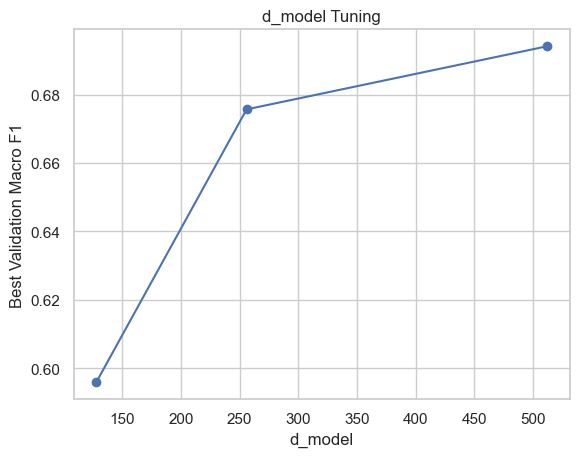

In [27]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    d_models = [128, 256, 512]
    results = {}

    for d in d_models:
        print(f"\nTraining with d_model = {d}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=d,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[d] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("d_model")
    plt.ylabel("Best Validation Macro F1")
    plt.title("d_model Tuning")
    plt.show()

    D_MODEL = max(results, key=results.get)



Training with num_heads = 4


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4431 Acc: 0.3555 | Val Loss: 0.3743 Acc: 0.4505 | Val Macro-F1: 0.4077


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3572 Acc: 0.5093 | Val Loss: 0.3048 Acc: 0.5722 | Val Macro-F1: 0.5037


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2481 Acc: 0.6922 | Val Loss: 0.2860 Acc: 0.6351 | Val Macro-F1: 0.6140


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1757 Acc: 0.7882 | Val Loss: 0.2847 Acc: 0.6567 | Val Macro-F1: 0.6391


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1334 Acc: 0.8315 | Val Loss: 0.2938 Acc: 0.6763 | Val Macro-F1: 0.6442


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.1110 Acc: 0.8635 | Val Loss: 0.3128 Acc: 0.6928 | Val Macro-F1: 0.6641


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0958 Acc: 0.8816 | Val Loss: 0.3532 Acc: 0.6804 | Val Macro-F1: 0.6556


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0797 Acc: 0.8953 | Val Loss: 0.3899 Acc: 0.6876 | Val Macro-F1: 0.6564


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0685 Acc: 0.9198 | Val Loss: 0.4207 Acc: 0.6629 | Val Macro-F1: 0.6493


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0609 Acc: 0.9291 | Val Loss: 0.4309 Acc: 0.6948 | Val Macro-F1: 0.6663


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0562 Acc: 0.9355 | Val Loss: 0.4646 Acc: 0.7155 | Val Macro-F1: 0.6747


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0538 Acc: 0.9417 | Val Loss: 0.4849 Acc: 0.7113 | Val Macro-F1: 0.6742


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0496 Acc: 0.9489 | Val Loss: 0.5118 Acc: 0.6948 | Val Macro-F1: 0.6596


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0408 Acc: 0.9561 | Val Loss: 0.5889 Acc: 0.6918 | Val Macro-F1: 0.6637


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0418 Acc: 0.9641 | Val Loss: 0.5903 Acc: 0.7010 | Val Macro-F1: 0.6658


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0395 Acc: 0.9652 | Val Loss: 0.6726 Acc: 0.7113 | Val Macro-F1: 0.6727
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with num_heads = 8


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4630 Acc: 0.3429 | Val Loss: 0.4414 Acc: 0.2000 | Val Macro-F1: 0.1782


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3617 Acc: 0.5049 | Val Loss: 0.3821 Acc: 0.4567 | Val Macro-F1: 0.4025


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2587 Acc: 0.6816 | Val Loss: 0.2901 Acc: 0.6175 | Val Macro-F1: 0.5838


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1808 Acc: 0.7740 | Val Loss: 0.2818 Acc: 0.6309 | Val Macro-F1: 0.6094


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1409 Acc: 0.8282 | Val Loss: 0.2657 Acc: 0.6897 | Val Macro-F1: 0.6510


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.1126 Acc: 0.8584 | Val Loss: 0.2981 Acc: 0.6979 | Val Macro-F1: 0.6547


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0976 Acc: 0.8852 | Val Loss: 0.3136 Acc: 0.6876 | Val Macro-F1: 0.6608


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0798 Acc: 0.9012 | Val Loss: 0.3439 Acc: 0.6876 | Val Macro-F1: 0.6595


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0694 Acc: 0.9164 | Val Loss: 0.3843 Acc: 0.7186 | Val Macro-F1: 0.6789


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0636 Acc: 0.9239 | Val Loss: 0.4268 Acc: 0.7113 | Val Macro-F1: 0.6855


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0550 Acc: 0.9321 | Val Loss: 0.4358 Acc: 0.7041 | Val Macro-F1: 0.6762


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0559 Acc: 0.9303 | Val Loss: 0.4479 Acc: 0.7134 | Val Macro-F1: 0.6867


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0503 Acc: 0.9396 | Val Loss: 0.4519 Acc: 0.7361 | Val Macro-F1: 0.6936


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0411 Acc: 0.9525 | Val Loss: 0.5645 Acc: 0.7258 | Val Macro-F1: 0.6894


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0445 Acc: 0.9605 | Val Loss: 0.5536 Acc: 0.7320 | Val Macro-F1: 0.6945


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0392 Acc: 0.9634 | Val Loss: 0.5510 Acc: 0.7196 | Val Macro-F1: 0.6863


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0342 Acc: 0.9665 | Val Loss: 0.6496 Acc: 0.7289 | Val Macro-F1: 0.6946


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0341 Acc: 0.9680 | Val Loss: 0.6915 Acc: 0.7351 | Val Macro-F1: 0.6998


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0322 Acc: 0.9727 | Val Loss: 0.7297 Acc: 0.7433 | Val Macro-F1: 0.7051


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0279 Acc: 0.9729 | Val Loss: 0.7768 Acc: 0.7412 | Val Macro-F1: 0.7012


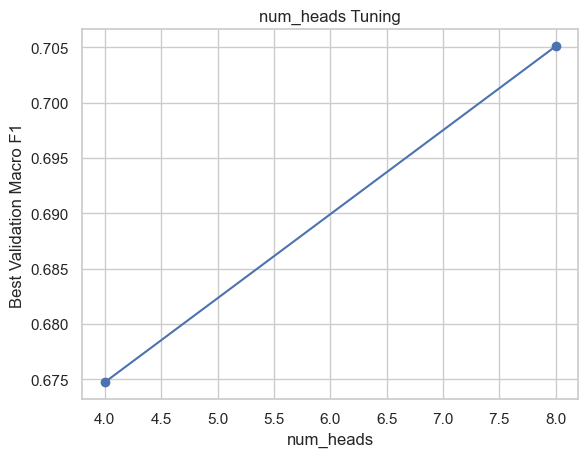

In [28]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    num_heads = [4, 8]
    results = {}

    for n in num_heads:
        print(f"\nTraining with num_heads = {n}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=n,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[n] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("num_heads")
    plt.ylabel("Best Validation Macro F1")
    plt.title("num_heads Tuning")
    plt.show()

    NUM_HEADS = max(results, key=results.get)



Training with num_layers = 2


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4555 Acc: 0.3444 | Val Loss: 0.3947 Acc: 0.2598 | Val Macro-F1: 0.2206


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3623 Acc: 0.4954 | Val Loss: 0.3270 Acc: 0.5515 | Val Macro-F1: 0.4835


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2480 Acc: 0.6814 | Val Loss: 0.2999 Acc: 0.5959 | Val Macro-F1: 0.5799


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1941 Acc: 0.7686 | Val Loss: 0.2888 Acc: 0.6381 | Val Macro-F1: 0.6166


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1505 Acc: 0.8055 | Val Loss: 0.3148 Acc: 0.6392 | Val Macro-F1: 0.6241


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.1175 Acc: 0.8465 | Val Loss: 0.3370 Acc: 0.6691 | Val Macro-F1: 0.6370


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0987 Acc: 0.8767 | Val Loss: 0.3507 Acc: 0.7072 | Val Macro-F1: 0.6763


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0836 Acc: 0.8996 | Val Loss: 0.3769 Acc: 0.6948 | Val Macro-F1: 0.6695


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0777 Acc: 0.9061 | Val Loss: 0.3810 Acc: 0.6814 | Val Macro-F1: 0.6616


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0764 Acc: 0.9094 | Val Loss: 0.4004 Acc: 0.6918 | Val Macro-F1: 0.6674


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0658 Acc: 0.9177 | Val Loss: 0.4174 Acc: 0.7155 | Val Macro-F1: 0.6806


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0596 Acc: 0.9257 | Val Loss: 0.4462 Acc: 0.7299 | Val Macro-F1: 0.6911


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0607 Acc: 0.9291 | Val Loss: 0.4385 Acc: 0.7402 | Val Macro-F1: 0.6944


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0538 Acc: 0.9363 | Val Loss: 0.4565 Acc: 0.7062 | Val Macro-F1: 0.6749


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0536 Acc: 0.9373 | Val Loss: 0.4895 Acc: 0.7072 | Val Macro-F1: 0.6745


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0471 Acc: 0.9445 | Val Loss: 0.5145 Acc: 0.7103 | Val Macro-F1: 0.6770


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0454 Acc: 0.9450 | Val Loss: 0.5489 Acc: 0.7289 | Val Macro-F1: 0.6853


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0431 Acc: 0.9520 | Val Loss: 0.5650 Acc: 0.7072 | Val Macro-F1: 0.6751
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with num_layers = 3


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4524 Acc: 0.3664 | Val Loss: 0.3971 Acc: 0.3031 | Val Macro-F1: 0.2821


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3494 Acc: 0.5199 | Val Loss: 0.3038 Acc: 0.5907 | Val Macro-F1: 0.5542


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2268 Acc: 0.7239 | Val Loss: 0.2770 Acc: 0.6412 | Val Macro-F1: 0.6080


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1739 Acc: 0.8039 | Val Loss: 0.2808 Acc: 0.6794 | Val Macro-F1: 0.6450


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1295 Acc: 0.8467 | Val Loss: 0.3110 Acc: 0.6588 | Val Macro-F1: 0.6281


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.0988 Acc: 0.8873 | Val Loss: 0.3435 Acc: 0.6794 | Val Macro-F1: 0.6459


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0842 Acc: 0.8983 | Val Loss: 0.3854 Acc: 0.6897 | Val Macro-F1: 0.6614


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0715 Acc: 0.9110 | Val Loss: 0.4105 Acc: 0.6629 | Val Macro-F1: 0.6433


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0639 Acc: 0.9195 | Val Loss: 0.4505 Acc: 0.7299 | Val Macro-F1: 0.6802


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0583 Acc: 0.9368 | Val Loss: 0.4624 Acc: 0.7206 | Val Macro-F1: 0.6770


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0542 Acc: 0.9345 | Val Loss: 0.4725 Acc: 0.7093 | Val Macro-F1: 0.6690


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0486 Acc: 0.9476 | Val Loss: 0.5107 Acc: 0.7144 | Val Macro-F1: 0.6716


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0449 Acc: 0.9453 | Val Loss: 0.5530 Acc: 0.7227 | Val Macro-F1: 0.6756


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0409 Acc: 0.9523 | Val Loss: 0.6274 Acc: 0.7247 | Val Macro-F1: 0.6822


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0384 Acc: 0.9549 | Val Loss: 0.6549 Acc: 0.7196 | Val Macro-F1: 0.6789


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0356 Acc: 0.9631 | Val Loss: 0.7118 Acc: 0.7423 | Val Macro-F1: 0.6969


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0299 Acc: 0.9716 | Val Loss: 0.7456 Acc: 0.7206 | Val Macro-F1: 0.6843


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0322 Acc: 0.9701 | Val Loss: 0.7413 Acc: 0.7278 | Val Macro-F1: 0.6842


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0288 Acc: 0.9755 | Val Loss: 0.7478 Acc: 0.7237 | Val Macro-F1: 0.6836


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0276 Acc: 0.9757 | Val Loss: 0.8242 Acc: 0.7320 | Val Macro-F1: 0.6918

Training with num_layers = 4


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4403 Acc: 0.3674 | Val Loss: 0.3783 Acc: 0.3825 | Val Macro-F1: 0.3509


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3357 Acc: 0.5493 | Val Loss: 0.3247 Acc: 0.5526 | Val Macro-F1: 0.5141


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2227 Acc: 0.7288 | Val Loss: 0.3113 Acc: 0.6536 | Val Macro-F1: 0.5987


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1583 Acc: 0.8096 | Val Loss: 0.3064 Acc: 0.6763 | Val Macro-F1: 0.6393


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1193 Acc: 0.8594 | Val Loss: 0.3276 Acc: 0.6907 | Val Macro-F1: 0.6500


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.0916 Acc: 0.8826 | Val Loss: 0.3853 Acc: 0.7052 | Val Macro-F1: 0.6651


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0768 Acc: 0.8983 | Val Loss: 0.4058 Acc: 0.7206 | Val Macro-F1: 0.6688


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0672 Acc: 0.9177 | Val Loss: 0.4082 Acc: 0.7082 | Val Macro-F1: 0.6694


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0590 Acc: 0.9177 | Val Loss: 0.4739 Acc: 0.6887 | Val Macro-F1: 0.6539


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0540 Acc: 0.9329 | Val Loss: 0.4915 Acc: 0.7103 | Val Macro-F1: 0.6712


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0444 Acc: 0.9461 | Val Loss: 0.5200 Acc: 0.7010 | Val Macro-F1: 0.6665


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0435 Acc: 0.9370 | Val Loss: 0.5441 Acc: 0.7041 | Val Macro-F1: 0.6716


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0428 Acc: 0.9479 | Val Loss: 0.5798 Acc: 0.7381 | Val Macro-F1: 0.6827


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0349 Acc: 0.9649 | Val Loss: 0.6402 Acc: 0.7196 | Val Macro-F1: 0.6781


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0331 Acc: 0.9657 | Val Loss: 0.6151 Acc: 0.7247 | Val Macro-F1: 0.6825


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0302 Acc: 0.9680 | Val Loss: 0.7201 Acc: 0.7351 | Val Macro-F1: 0.6904


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0298 Acc: 0.9727 | Val Loss: 0.8021 Acc: 0.7113 | Val Macro-F1: 0.6737


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0265 Acc: 0.9786 | Val Loss: 0.7802 Acc: 0.7361 | Val Macro-F1: 0.6885


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0220 Acc: 0.9812 | Val Loss: 0.8771 Acc: 0.7320 | Val Macro-F1: 0.6948


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0219 Acc: 0.9837 | Val Loss: 0.8966 Acc: 0.7309 | Val Macro-F1: 0.6889


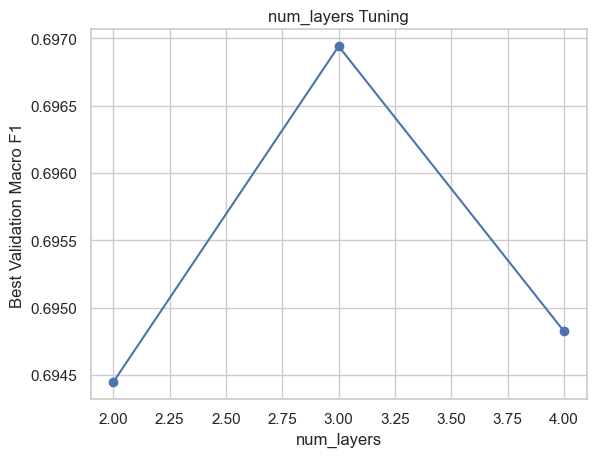

In [29]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    num_layers = [2, 3, 4]
    results = {}

    for n in num_layers:
        print(f"\nTraining with num_layers = {n}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=n,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[n] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("num_layers")
    plt.ylabel("Best Validation Macro F1")
    plt.title("num_layers Tuning")
    plt.show()

    NUM_LAYERS = max(results, key=results.get)



Training with ff_hidden_dim = 1024


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4603 Acc: 0.3233 | Val Loss: 0.3814 Acc: 0.3990 | Val Macro-F1: 0.3040


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3595 Acc: 0.4930 | Val Loss: 0.4034 Acc: 0.4608 | Val Macro-F1: 0.4494


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2419 Acc: 0.7012 | Val Loss: 0.3050 Acc: 0.6155 | Val Macro-F1: 0.5899


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1754 Acc: 0.7807 | Val Loss: 0.3046 Acc: 0.6814 | Val Macro-F1: 0.6315


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1371 Acc: 0.8284 | Val Loss: 0.3179 Acc: 0.7041 | Val Macro-F1: 0.6621


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.1171 Acc: 0.8578 | Val Loss: 0.3186 Acc: 0.7021 | Val Macro-F1: 0.6602


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0928 Acc: 0.8852 | Val Loss: 0.3532 Acc: 0.6825 | Val Macro-F1: 0.6564


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0787 Acc: 0.8971 | Val Loss: 0.3699 Acc: 0.6732 | Val Macro-F1: 0.6428


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0711 Acc: 0.9035 | Val Loss: 0.3954 Acc: 0.6773 | Val Macro-F1: 0.6503


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0687 Acc: 0.9143 | Val Loss: 0.4089 Acc: 0.7155 | Val Macro-F1: 0.6775


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0589 Acc: 0.9174 | Val Loss: 0.4578 Acc: 0.7072 | Val Macro-F1: 0.6790


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0549 Acc: 0.9363 | Val Loss: 0.4516 Acc: 0.7278 | Val Macro-F1: 0.6882


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0493 Acc: 0.9420 | Val Loss: 0.4746 Acc: 0.7340 | Val Macro-F1: 0.6934


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0468 Acc: 0.9494 | Val Loss: 0.5493 Acc: 0.7124 | Val Macro-F1: 0.6763


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0458 Acc: 0.9487 | Val Loss: 0.5204 Acc: 0.7423 | Val Macro-F1: 0.7015


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0410 Acc: 0.9608 | Val Loss: 0.5657 Acc: 0.7505 | Val Macro-F1: 0.7089


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0396 Acc: 0.9618 | Val Loss: 0.5954 Acc: 0.7474 | Val Macro-F1: 0.7042


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0357 Acc: 0.9623 | Val Loss: 0.6304 Acc: 0.7515 | Val Macro-F1: 0.6990


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0345 Acc: 0.9685 | Val Loss: 0.6400 Acc: 0.7134 | Val Macro-F1: 0.6828


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0310 Acc: 0.9724 | Val Loss: 0.6845 Acc: 0.7433 | Val Macro-F1: 0.7025

Training with ff_hidden_dim = 2048


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.4435 Acc: 0.3682 | Val Loss: 0.4136 Acc: 0.2392 | Val Macro-F1: 0.2182


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.3424 Acc: 0.5418 | Val Loss: 0.3369 Acc: 0.5052 | Val Macro-F1: 0.4882


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.2275 Acc: 0.7216 | Val Loss: 0.2959 Acc: 0.6536 | Val Macro-F1: 0.6137


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.1661 Acc: 0.7915 | Val Loss: 0.3284 Acc: 0.6093 | Val Macro-F1: 0.5849


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.1257 Acc: 0.8460 | Val Loss: 0.3264 Acc: 0.6320 | Val Macro-F1: 0.6106


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.0949 Acc: 0.8811 | Val Loss: 0.3609 Acc: 0.7021 | Val Macro-F1: 0.6526


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0797 Acc: 0.8978 | Val Loss: 0.4049 Acc: 0.6856 | Val Macro-F1: 0.6524


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0678 Acc: 0.9123 | Val Loss: 0.4117 Acc: 0.6773 | Val Macro-F1: 0.6418


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0606 Acc: 0.9229 | Val Loss: 0.4449 Acc: 0.7134 | Val Macro-F1: 0.6670


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0585 Acc: 0.9309 | Val Loss: 0.4573 Acc: 0.7175 | Val Macro-F1: 0.6699


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0500 Acc: 0.9396 | Val Loss: 0.4794 Acc: 0.6938 | Val Macro-F1: 0.6559


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0462 Acc: 0.9458 | Val Loss: 0.5030 Acc: 0.7165 | Val Macro-F1: 0.6703


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0421 Acc: 0.9569 | Val Loss: 0.5294 Acc: 0.7041 | Val Macro-F1: 0.6690


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0396 Acc: 0.9543 | Val Loss: 0.6121 Acc: 0.7175 | Val Macro-F1: 0.6706


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0330 Acc: 0.9641 | Val Loss: 0.6747 Acc: 0.7206 | Val Macro-F1: 0.6773


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0323 Acc: 0.9690 | Val Loss: 0.6746 Acc: 0.7165 | Val Macro-F1: 0.6763


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0309 Acc: 0.9721 | Val Loss: 0.7210 Acc: 0.7216 | Val Macro-F1: 0.6776


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0292 Acc: 0.9729 | Val Loss: 0.8221 Acc: 0.7268 | Val Macro-F1: 0.6816


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0283 Acc: 0.9778 | Val Loss: 0.7940 Acc: 0.7196 | Val Macro-F1: 0.6774


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0272 Acc: 0.9799 | Val Loss: 0.7605 Acc: 0.7299 | Val Macro-F1: 0.6822


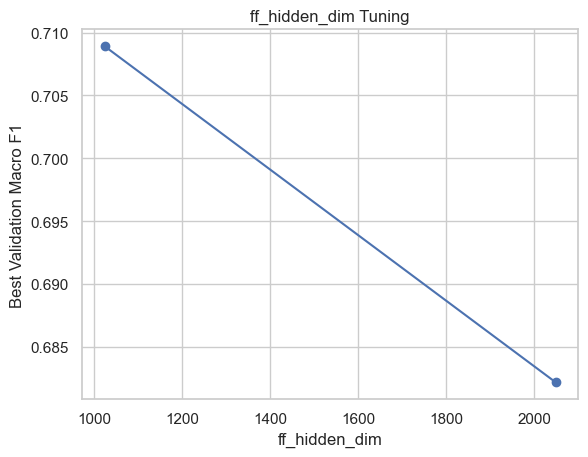

In [30]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    ff_hidden_dim = [2 * D_MODEL, 4 * D_MODEL]
    results = {}

    for n in ff_hidden_dim:
        print(f"\nTraining with ff_hidden_dim = {n}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=n,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[n] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("ff_hidden_dim")
    plt.ylabel("Best Validation Macro F1")
    plt.title("ff_hidden_dim Tuning")
    plt.show()

    FF_HIDDEN_DIM = max(results, key=results.get)



Training with dropout_val = 0.1


Epoch 1/30 | Train Loss: 0.4529 Acc: 0.3400 | Val Loss: 0.4236 Acc: 0.1660 | Val Macro-F1: 0.1455


Epoch 2/30 | Train Loss: 0.3733 Acc: 0.4724 | Val Loss: 0.3810 Acc: 0.4031 | Val Macro-F1: 0.3435


Epoch 3/30 | Train Loss: 0.2630 Acc: 0.6662 | Val Loss: 0.3035 Acc: 0.5979 | Val Macro-F1: 0.5673


Epoch 4/30 | Train Loss: 0.1768 Acc: 0.7797 | Val Loss: 0.3207 Acc: 0.5969 | Val Macro-F1: 0.5708


Epoch 5/30 | Train Loss: 0.1263 Acc: 0.8447 | Val Loss: 0.3408 Acc: 0.6495 | Val Macro-F1: 0.6198


Epoch 6/30 | Train Loss: 0.1109 Acc: 0.8622 | Val Loss: 0.3423 Acc: 0.6577 | Val Macro-F1: 0.6316


Epoch 7/30 | Train Loss: 0.0852 Acc: 0.8798 | Val Loss: 0.4439 Acc: 0.5948 | Val Macro-F1: 0.6039


Epoch 8/30 | Train Loss: 0.0721 Acc: 0.8976 | Val Loss: 0.4440 Acc: 0.7052 | Val Macro-F1: 0.6704


Epoch 9/30 | Train Loss: 0.0616 Acc: 0.9187 | Val Loss: 0.4698 Acc: 0.6948 | Val Macro-F1: 0.6615


Epoch 10/30 | Train Loss: 0.0548 Acc: 0.9389 | Val Loss: 0.5054 Acc: 0.6969 | Val Macro-F1: 0.6668


Epoch 11/30 | Train Loss: 0.0515 Acc: 0.9474 | Val Loss: 0.5022 Acc: 0.7268 | Val Macro-F1: 0.6822


Epoch 12/30 | Train Loss: 0.0429 Acc: 0.9499 | Val Loss: 0.5578 Acc: 0.7216 | Val Macro-F1: 0.6820


Epoch 13/30 | Train Loss: 0.0399 Acc: 0.9582 | Val Loss: 0.5919 Acc: 0.7258 | Val Macro-F1: 0.6881


Epoch 14/30 | Train Loss: 0.0365 Acc: 0.9621 | Val Loss: 0.5998 Acc: 0.7309 | Val Macro-F1: 0.6885


Epoch 15/30 | Train Loss: 0.0349 Acc: 0.9680 | Val Loss: 0.6738 Acc: 0.7412 | Val Macro-F1: 0.6959


Epoch 16/30 | Train Loss: 0.0321 Acc: 0.9742 | Val Loss: 0.6564 Acc: 0.7247 | Val Macro-F1: 0.6815


Epoch 17/30 | Train Loss: 0.0308 Acc: 0.9739 | Val Loss: 0.6608 Acc: 0.7268 | Val Macro-F1: 0.6902


Epoch 18/30 | Train Loss: 0.0280 Acc: 0.9791 | Val Loss: 0.7688 Acc: 0.7495 | Val Macro-F1: 0.7007


Epoch 19/30 | Train Loss: 0.0259 Acc: 0.9781 | Val Loss: 0.7957 Acc: 0.7423 | Val Macro-F1: 0.6982


Epoch 20/30 | Train Loss: 0.0252 Acc: 0.9825 | Val Loss: 0.8250 Acc: 0.7155 | Val Macro-F1: 0.6852


Epoch 21/30 | Train Loss: 0.0230 Acc: 0.9840 | Val Loss: 0.8185 Acc: 0.7381 | Val Macro-F1: 0.6957


Epoch 22/30 | Train Loss: 0.0206 Acc: 0.9868 | Val Loss: 0.8709 Acc: 0.7196 | Val Macro-F1: 0.6881


Epoch 23/30 | Train Loss: 0.0199 Acc: 0.9884 | Val Loss: 0.8823 Acc: 0.7381 | Val Macro-F1: 0.6965
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with dropout_val = 0.2


Epoch 1/30 | Train Loss: 0.4580 Acc: 0.3297 | Val Loss: 0.4285 Acc: 0.1639 | Val Macro-F1: 0.1394


Epoch 2/30 | Train Loss: 0.3725 Acc: 0.4649 | Val Loss: 0.4425 Acc: 0.3691 | Val Macro-F1: 0.3454


Epoch 3/30 | Train Loss: 0.2756 Acc: 0.6597 | Val Loss: 0.2809 Acc: 0.6175 | Val Macro-F1: 0.5822


Epoch 4/30 | Train Loss: 0.1832 Acc: 0.7828 | Val Loss: 0.2859 Acc: 0.6567 | Val Macro-F1: 0.6210


Epoch 5/30 | Train Loss: 0.1406 Acc: 0.8331 | Val Loss: 0.2817 Acc: 0.6969 | Val Macro-F1: 0.6567


Epoch 6/30 | Train Loss: 0.1078 Acc: 0.8612 | Val Loss: 0.3273 Acc: 0.6588 | Val Macro-F1: 0.6383


Epoch 7/30 | Train Loss: 0.0949 Acc: 0.8764 | Val Loss: 0.3313 Acc: 0.7041 | Val Macro-F1: 0.6720


Epoch 8/30 | Train Loss: 0.0758 Acc: 0.9061 | Val Loss: 0.3897 Acc: 0.7186 | Val Macro-F1: 0.6713


Epoch 9/30 | Train Loss: 0.0679 Acc: 0.9112 | Val Loss: 0.3988 Acc: 0.7052 | Val Macro-F1: 0.6687


Epoch 10/30 | Train Loss: 0.0593 Acc: 0.9260 | Val Loss: 0.4139 Acc: 0.7278 | Val Macro-F1: 0.6804


Epoch 11/30 | Train Loss: 0.0548 Acc: 0.9334 | Val Loss: 0.4616 Acc: 0.7381 | Val Macro-F1: 0.6888


Epoch 12/30 | Train Loss: 0.0500 Acc: 0.9445 | Val Loss: 0.4321 Acc: 0.7351 | Val Macro-F1: 0.6947


Epoch 13/30 | Train Loss: 0.0419 Acc: 0.9453 | Val Loss: 0.5047 Acc: 0.7423 | Val Macro-F1: 0.6988


Epoch 14/30 | Train Loss: 0.0408 Acc: 0.9546 | Val Loss: 0.4957 Acc: 0.7258 | Val Macro-F1: 0.6905


Epoch 15/30 | Train Loss: 0.0343 Acc: 0.9678 | Val Loss: 0.6306 Acc: 0.7124 | Val Macro-F1: 0.6778


Epoch 16/30 | Train Loss: 0.0339 Acc: 0.9708 | Val Loss: 0.6722 Acc: 0.7268 | Val Macro-F1: 0.6833


Epoch 17/30 | Train Loss: 0.0321 Acc: 0.9708 | Val Loss: 0.6707 Acc: 0.7268 | Val Macro-F1: 0.6881


Epoch 18/30 | Train Loss: 0.0277 Acc: 0.9745 | Val Loss: 0.7021 Acc: 0.7268 | Val Macro-F1: 0.6925
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with dropout_val = 0.3


Epoch 1/30 | Train Loss: 0.4641 Acc: 0.3359 | Val Loss: 0.4125 Acc: 0.2196 | Val Macro-F1: 0.2157


Epoch 2/30 | Train Loss: 0.3816 Acc: 0.4693 | Val Loss: 0.3388 Acc: 0.4907 | Val Macro-F1: 0.4100


Epoch 3/30 | Train Loss: 0.2895 Acc: 0.6305 | Val Loss: 0.3047 Acc: 0.5845 | Val Macro-F1: 0.5524


Epoch 4/30 | Train Loss: 0.2042 Acc: 0.7500 | Val Loss: 0.2804 Acc: 0.6196 | Val Macro-F1: 0.6056


Epoch 5/30 | Train Loss: 0.1501 Acc: 0.8166 | Val Loss: 0.2901 Acc: 0.6825 | Val Macro-F1: 0.6533


Epoch 6/30 | Train Loss: 0.1128 Acc: 0.8596 | Val Loss: 0.3084 Acc: 0.6907 | Val Macro-F1: 0.6591


Epoch 7/30 | Train Loss: 0.0958 Acc: 0.8813 | Val Loss: 0.3160 Acc: 0.6918 | Val Macro-F1: 0.6582


Epoch 8/30 | Train Loss: 0.0743 Acc: 0.9038 | Val Loss: 0.3618 Acc: 0.6784 | Val Macro-F1: 0.6586


Epoch 9/30 | Train Loss: 0.0708 Acc: 0.9063 | Val Loss: 0.3791 Acc: 0.7124 | Val Macro-F1: 0.6797


Epoch 10/30 | Train Loss: 0.0605 Acc: 0.9213 | Val Loss: 0.4077 Acc: 0.7052 | Val Macro-F1: 0.6816


Epoch 11/30 | Train Loss: 0.0540 Acc: 0.9334 | Val Loss: 0.4376 Acc: 0.7196 | Val Macro-F1: 0.6866


Epoch 12/30 | Train Loss: 0.0505 Acc: 0.9394 | Val Loss: 0.4251 Acc: 0.7124 | Val Macro-F1: 0.6789


Epoch 13/30 | Train Loss: 0.0452 Acc: 0.9499 | Val Loss: 0.4789 Acc: 0.7227 | Val Macro-F1: 0.6806


Epoch 14/30 | Train Loss: 0.0431 Acc: 0.9569 | Val Loss: 0.4764 Acc: 0.7392 | Val Macro-F1: 0.6960


Epoch 15/30 | Train Loss: 0.0372 Acc: 0.9561 | Val Loss: 0.5435 Acc: 0.7474 | Val Macro-F1: 0.7008


Epoch 16/30 | Train Loss: 0.0371 Acc: 0.9616 | Val Loss: 0.5977 Acc: 0.7309 | Val Macro-F1: 0.6969


Epoch 17/30 | Train Loss: 0.0311 Acc: 0.9698 | Val Loss: 0.7151 Acc: 0.7320 | Val Macro-F1: 0.6962


Epoch 18/30 | Train Loss: 0.0306 Acc: 0.9755 | Val Loss: 0.6901 Acc: 0.7186 | Val Macro-F1: 0.6857


Epoch 19/30 | Train Loss: 0.0305 Acc: 0.9721 | Val Loss: 0.6729 Acc: 0.7402 | Val Macro-F1: 0.6948


Epoch 20/30 | Train Loss: 0.0263 Acc: 0.9799 | Val Loss: 0.6920 Acc: 0.7340 | Val Macro-F1: 0.6980
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with dropout_val = 0.4


Epoch 1/30 | Train Loss: 0.4537 Acc: 0.3535 | Val Loss: 0.4199 Acc: 0.1639 | Val Macro-F1: 0.1440


Epoch 2/30 | Train Loss: 0.3780 Acc: 0.4520 | Val Loss: 0.3903 Acc: 0.4485 | Val Macro-F1: 0.4321


Epoch 3/30 | Train Loss: 0.2894 Acc: 0.6249 | Val Loss: 0.3048 Acc: 0.5825 | Val Macro-F1: 0.5540


Epoch 4/30 | Train Loss: 0.2017 Acc: 0.7513 | Val Loss: 0.2826 Acc: 0.6577 | Val Macro-F1: 0.6134


Epoch 5/30 | Train Loss: 0.1473 Acc: 0.8044 | Val Loss: 0.3088 Acc: 0.6691 | Val Macro-F1: 0.6377


Epoch 6/30 | Train Loss: 0.1153 Acc: 0.8506 | Val Loss: 0.3349 Acc: 0.6804 | Val Macro-F1: 0.6521


Epoch 7/30 | Train Loss: 0.0874 Acc: 0.8896 | Val Loss: 0.3741 Acc: 0.6969 | Val Macro-F1: 0.6690


Epoch 8/30 | Train Loss: 0.0748 Acc: 0.8968 | Val Loss: 0.4341 Acc: 0.6505 | Val Macro-F1: 0.6374


Epoch 9/30 | Train Loss: 0.0684 Acc: 0.9143 | Val Loss: 0.4138 Acc: 0.6948 | Val Macro-F1: 0.6666


Epoch 10/30 | Train Loss: 0.0593 Acc: 0.9174 | Val Loss: 0.4520 Acc: 0.7237 | Val Macro-F1: 0.6850


Epoch 11/30 | Train Loss: 0.0503 Acc: 0.9352 | Val Loss: 0.4853 Acc: 0.7124 | Val Macro-F1: 0.6818


Epoch 12/30 | Train Loss: 0.0460 Acc: 0.9389 | Val Loss: 0.5893 Acc: 0.7299 | Val Macro-F1: 0.6918


Epoch 13/30 | Train Loss: 0.0453 Acc: 0.9396 | Val Loss: 0.5847 Acc: 0.7309 | Val Macro-F1: 0.6942


Epoch 14/30 | Train Loss: 0.0388 Acc: 0.9595 | Val Loss: 0.6281 Acc: 0.7082 | Val Macro-F1: 0.6757


Epoch 15/30 | Train Loss: 0.0421 Acc: 0.9595 | Val Loss: 0.6425 Acc: 0.7247 | Val Macro-F1: 0.6869


Epoch 16/30 | Train Loss: 0.0363 Acc: 0.9647 | Val Loss: 0.6203 Acc: 0.7299 | Val Macro-F1: 0.6862


Epoch 17/30 | Train Loss: 0.0331 Acc: 0.9641 | Val Loss: 0.7097 Acc: 0.7000 | Val Macro-F1: 0.6684


Epoch 18/30 | Train Loss: 0.0326 Acc: 0.9703 | Val Loss: 0.7180 Acc: 0.7268 | Val Macro-F1: 0.6885
Early stopping: no improvement in Macro-F1 for 5 epochs.


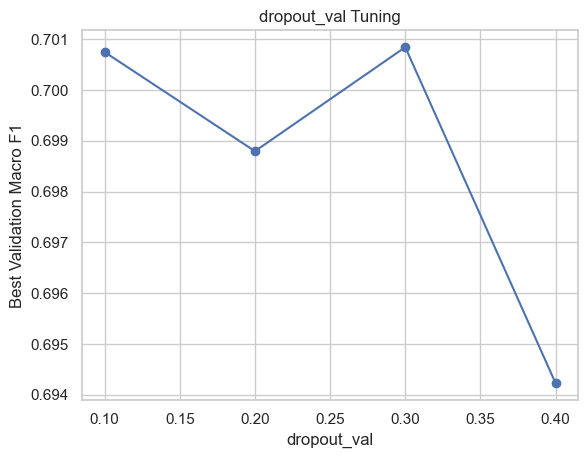

In [50]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    results = {}

    for d in [0.1, 0.2, 0.3, 0.4]:
        print(f"\nTraining with dropout_val = {d}")


        dropout_val = d

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)
        best_f1 = max(history['val_macro_f1'])
        results[d] = best_f1


    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("dropout_val")
    plt.ylabel("Best Validation Macro F1")
    plt.title("dropout_val Tuning")
    plt.show()

    dropout_val = max(results, key=results.get)



Training with learning rate = 5e-05


Epoch 1/20 | Train Loss: 0.4795 Acc: 0.3349 | Val Loss: 0.4347 Acc: 0.1454 | Val Macro-F1: 0.1169


Epoch 2/20 | Train Loss: 0.4393 Acc: 0.3475 | Val Loss: 0.4221 Acc: 0.1701 | Val Macro-F1: 0.1542


Epoch 3/20 | Train Loss: 0.3983 Acc: 0.4221 | Val Loss: 0.3977 Acc: 0.3258 | Val Macro-F1: 0.2817


Epoch 4/20 | Train Loss: 0.3742 Acc: 0.4822 | Val Loss: 0.3706 Acc: 0.4186 | Val Macro-F1: 0.3588


Epoch 5/20 | Train Loss: 0.3567 Acc: 0.5088 | Val Loss: 0.3789 Acc: 0.4155 | Val Macro-F1: 0.3789


Epoch 6/20 | Train Loss: 0.3346 Acc: 0.5402 | Val Loss: 0.3622 Acc: 0.4639 | Val Macro-F1: 0.4260


Epoch 7/20 | Train Loss: 0.3213 Acc: 0.5550 | Val Loss: 0.3428 Acc: 0.4938 | Val Macro-F1: 0.4484


Epoch 8/20 | Train Loss: 0.3137 Acc: 0.5740 | Val Loss: 0.3281 Acc: 0.5320 | Val Macro-F1: 0.4958


Epoch 9/20 | Train Loss: 0.2991 Acc: 0.6164 | Val Loss: 0.3292 Acc: 0.5381 | Val Macro-F1: 0.5106


Epoch 10/20 | Train Loss: 0.2876 Acc: 0.6277 | Val Loss: 0.3230 Acc: 0.5433 | Val Macro-F1: 0.5039


Epoch 11/20 | Train Loss: 0.2778 Acc: 0.6569 | Val Loss: 0.3361 Acc: 0.5361 | Val Macro-F1: 0.5103


Epoch 12/20 | Train Loss: 0.2597 Acc: 0.6788 | Val Loss: 0.3105 Acc: 0.5649 | Val Macro-F1: 0.5278


Epoch 13/20 | Train Loss: 0.2461 Acc: 0.6979 | Val Loss: 0.3061 Acc: 0.5897 | Val Macro-F1: 0.5653


Epoch 14/20 | Train Loss: 0.2426 Acc: 0.6917 | Val Loss: 0.3102 Acc: 0.5814 | Val Macro-F1: 0.5545


Epoch 15/20 | Train Loss: 0.2349 Acc: 0.7162 | Val Loss: 0.3030 Acc: 0.6021 | Val Macro-F1: 0.5748


Epoch 16/20 | Train Loss: 0.2200 Acc: 0.7343 | Val Loss: 0.2956 Acc: 0.6196 | Val Macro-F1: 0.5898


Epoch 17/20 | Train Loss: 0.2261 Acc: 0.7157 | Val Loss: 0.2915 Acc: 0.6289 | Val Macro-F1: 0.5998


Epoch 18/20 | Train Loss: 0.2163 Acc: 0.7327 | Val Loss: 0.3030 Acc: 0.5979 | Val Macro-F1: 0.5831


Epoch 19/20 | Train Loss: 0.2036 Acc: 0.7464 | Val Loss: 0.2964 Acc: 0.6124 | Val Macro-F1: 0.5929


Epoch 20/20 | Train Loss: 0.2022 Acc: 0.7485 | Val Loss: 0.2982 Acc: 0.6113 | Val Macro-F1: 0.5850

Training with learning rate = 0.0001


Epoch 1/20 | Train Loss: 0.4575 Acc: 0.3550 | Val Loss: 0.4308 Acc: 0.1330 | Val Macro-F1: 0.0902


Epoch 2/20 | Train Loss: 0.4100 Acc: 0.3818 | Val Loss: 0.3927 Acc: 0.3216 | Val Macro-F1: 0.2856


Epoch 3/20 | Train Loss: 0.3519 Acc: 0.5095 | Val Loss: 0.3439 Acc: 0.4794 | Val Macro-F1: 0.4250


Epoch 4/20 | Train Loss: 0.3059 Acc: 0.6066 | Val Loss: 0.3277 Acc: 0.5340 | Val Macro-F1: 0.4985


Epoch 5/20 | Train Loss: 0.2632 Acc: 0.6809 | Val Loss: 0.3055 Acc: 0.5928 | Val Macro-F1: 0.5521


Epoch 6/20 | Train Loss: 0.2297 Acc: 0.7167 | Val Loss: 0.2977 Acc: 0.6041 | Val Macro-F1: 0.5805


Epoch 7/20 | Train Loss: 0.2055 Acc: 0.7456 | Val Loss: 0.2847 Acc: 0.6309 | Val Macro-F1: 0.6072


Epoch 8/20 | Train Loss: 0.1862 Acc: 0.7730 | Val Loss: 0.3173 Acc: 0.5918 | Val Macro-F1: 0.5690


Epoch 9/20 | Train Loss: 0.1780 Acc: 0.7861 | Val Loss: 0.2877 Acc: 0.6546 | Val Macro-F1: 0.6278


Epoch 10/20 | Train Loss: 0.1594 Acc: 0.8024 | Val Loss: 0.2997 Acc: 0.6567 | Val Macro-F1: 0.6264


Epoch 11/20 | Train Loss: 0.1462 Acc: 0.8050 | Val Loss: 0.3036 Acc: 0.6701 | Val Macro-F1: 0.6330


Epoch 12/20 | Train Loss: 0.1422 Acc: 0.8220 | Val Loss: 0.3062 Acc: 0.6763 | Val Macro-F1: 0.6409


Epoch 13/20 | Train Loss: 0.1316 Acc: 0.8326 | Val Loss: 0.3246 Acc: 0.6474 | Val Macro-F1: 0.6269


Epoch 14/20 | Train Loss: 0.1199 Acc: 0.8398 | Val Loss: 0.3258 Acc: 0.6856 | Val Macro-F1: 0.6530


Epoch 15/20 | Train Loss: 0.1173 Acc: 0.8506 | Val Loss: 0.3391 Acc: 0.6825 | Val Macro-F1: 0.6538


Epoch 16/20 | Train Loss: 0.1066 Acc: 0.8578 | Val Loss: 0.3511 Acc: 0.6814 | Val Macro-F1: 0.6556


Epoch 17/20 | Train Loss: 0.1064 Acc: 0.8591 | Val Loss: 0.3541 Acc: 0.6907 | Val Macro-F1: 0.6590


Epoch 18/20 | Train Loss: 0.1001 Acc: 0.8679 | Val Loss: 0.3632 Acc: 0.6918 | Val Macro-F1: 0.6617


Epoch 19/20 | Train Loss: 0.0978 Acc: 0.8689 | Val Loss: 0.3686 Acc: 0.7052 | Val Macro-F1: 0.6706


Epoch 20/20 | Train Loss: 0.0924 Acc: 0.8749 | Val Loss: 0.3838 Acc: 0.7031 | Val Macro-F1: 0.6655

Training with learning rate = 0.0002


Epoch 1/20 | Train Loss: 0.4707 Acc: 0.3197 | Val Loss: 0.4344 Acc: 0.1474 | Val Macro-F1: 0.1181


Epoch 2/20 | Train Loss: 0.3778 Acc: 0.4672 | Val Loss: 0.3603 Acc: 0.4887 | Val Macro-F1: 0.4596


Epoch 3/20 | Train Loss: 0.2927 Acc: 0.6176 | Val Loss: 0.3124 Acc: 0.5567 | Val Macro-F1: 0.5443


Epoch 4/20 | Train Loss: 0.2240 Acc: 0.7216 | Val Loss: 0.2700 Acc: 0.6515 | Val Macro-F1: 0.6201


Epoch 5/20 | Train Loss: 0.1799 Acc: 0.7730 | Val Loss: 0.2689 Acc: 0.6464 | Val Macro-F1: 0.6257


Epoch 6/20 | Train Loss: 0.1519 Acc: 0.8042 | Val Loss: 0.2886 Acc: 0.6351 | Val Macro-F1: 0.6220


Epoch 7/20 | Train Loss: 0.1342 Acc: 0.8253 | Val Loss: 0.2857 Acc: 0.6485 | Val Macro-F1: 0.6268


Epoch 8/20 | Train Loss: 0.1151 Acc: 0.8455 | Val Loss: 0.3034 Acc: 0.6526 | Val Macro-F1: 0.6391


Epoch 9/20 | Train Loss: 0.1010 Acc: 0.8710 | Val Loss: 0.3033 Acc: 0.7031 | Val Macro-F1: 0.6733


Epoch 10/20 | Train Loss: 0.0890 Acc: 0.8772 | Val Loss: 0.3310 Acc: 0.7010 | Val Macro-F1: 0.6690


Epoch 11/20 | Train Loss: 0.0883 Acc: 0.8775 | Val Loss: 0.3545 Acc: 0.6660 | Val Macro-F1: 0.6496


Epoch 12/20 | Train Loss: 0.0794 Acc: 0.8989 | Val Loss: 0.3547 Acc: 0.7052 | Val Macro-F1: 0.6775


Epoch 13/20 | Train Loss: 0.0745 Acc: 0.9002 | Val Loss: 0.3703 Acc: 0.7000 | Val Macro-F1: 0.6746


Epoch 14/20 | Train Loss: 0.0705 Acc: 0.9048 | Val Loss: 0.4002 Acc: 0.7010 | Val Macro-F1: 0.6696


Epoch 15/20 | Train Loss: 0.0675 Acc: 0.9156 | Val Loss: 0.3792 Acc: 0.7268 | Val Macro-F1: 0.6896


Epoch 16/20 | Train Loss: 0.0692 Acc: 0.9110 | Val Loss: 0.3782 Acc: 0.7103 | Val Macro-F1: 0.6752


Epoch 17/20 | Train Loss: 0.0626 Acc: 0.9241 | Val Loss: 0.3906 Acc: 0.7268 | Val Macro-F1: 0.6900


Epoch 18/20 | Train Loss: 0.0572 Acc: 0.9278 | Val Loss: 0.4022 Acc: 0.7052 | Val Macro-F1: 0.6807


Epoch 19/20 | Train Loss: 0.0580 Acc: 0.9280 | Val Loss: 0.4640 Acc: 0.6969 | Val Macro-F1: 0.6688


Epoch 20/20 | Train Loss: 0.0554 Acc: 0.9296 | Val Loss: 0.4364 Acc: 0.7361 | Val Macro-F1: 0.7030

Training with learning rate = 0.0005


Epoch 1/20 | Train Loss: 0.4429 Acc: 0.3571 | Val Loss: 0.3701 Acc: 0.4505 | Val Macro-F1: 0.3741


Epoch 2/20 | Train Loss: 0.3096 Acc: 0.5926 | Val Loss: 0.2994 Acc: 0.6247 | Val Macro-F1: 0.5674


Epoch 3/20 | Train Loss: 0.1833 Acc: 0.7851 | Val Loss: 0.2894 Acc: 0.6722 | Val Macro-F1: 0.6316


Epoch 4/20 | Train Loss: 0.1290 Acc: 0.8431 | Val Loss: 0.3555 Acc: 0.6227 | Val Macro-F1: 0.5978


Epoch 5/20 | Train Loss: 0.0903 Acc: 0.8857 | Val Loss: 0.3817 Acc: 0.7124 | Val Macro-F1: 0.6671


Epoch 6/20 | Train Loss: 0.0729 Acc: 0.9102 | Val Loss: 0.4204 Acc: 0.7021 | Val Macro-F1: 0.6646


Epoch 7/20 | Train Loss: 0.0613 Acc: 0.9192 | Val Loss: 0.4518 Acc: 0.7103 | Val Macro-F1: 0.6620


Epoch 8/20 | Train Loss: 0.0496 Acc: 0.9417 | Val Loss: 0.4951 Acc: 0.7031 | Val Macro-F1: 0.6660


Epoch 9/20 | Train Loss: 0.0454 Acc: 0.9499 | Val Loss: 0.5633 Acc: 0.7247 | Val Macro-F1: 0.6762


Epoch 10/20 | Train Loss: 0.0410 Acc: 0.9572 | Val Loss: 0.5606 Acc: 0.7247 | Val Macro-F1: 0.6760


Epoch 11/20 | Train Loss: 0.0352 Acc: 0.9634 | Val Loss: 0.6085 Acc: 0.7144 | Val Macro-F1: 0.6757


Epoch 12/20 | Train Loss: 0.0323 Acc: 0.9675 | Val Loss: 0.6765 Acc: 0.7299 | Val Macro-F1: 0.6848


Epoch 13/20 | Train Loss: 0.0284 Acc: 0.9711 | Val Loss: 0.7266 Acc: 0.7216 | Val Macro-F1: 0.6837


Epoch 14/20 | Train Loss: 0.0273 Acc: 0.9783 | Val Loss: 0.7264 Acc: 0.7433 | Val Macro-F1: 0.6889


Epoch 15/20 | Train Loss: 0.0263 Acc: 0.9799 | Val Loss: 0.7461 Acc: 0.7351 | Val Macro-F1: 0.6867


Epoch 16/20 | Train Loss: 0.0252 Acc: 0.9825 | Val Loss: 0.7691 Acc: 0.7361 | Val Macro-F1: 0.6875


Epoch 17/20 | Train Loss: 0.0207 Acc: 0.9866 | Val Loss: 0.8398 Acc: 0.7351 | Val Macro-F1: 0.6811


Epoch 18/20 | Train Loss: 0.0178 Acc: 0.9899 | Val Loss: 0.8682 Acc: 0.7330 | Val Macro-F1: 0.6853


Epoch 19/20 | Train Loss: 0.0171 Acc: 0.9920 | Val Loss: 0.9322 Acc: 0.7392 | Val Macro-F1: 0.6875
Early stopping: no improvement in Macro-F1 for 5 epochs.


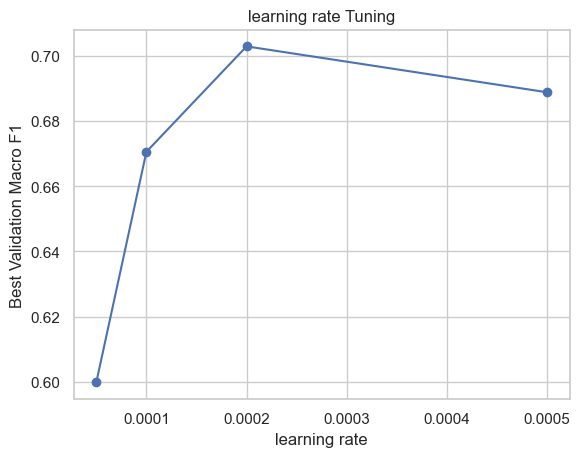

In [53]:
# (Optional) hyperparameter tuning cell

if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    results = {}


    for lr in [5e-5, 1e-4, 2e-4, 5e-4]:
        print(f"\nTraining with learning rate = {lr}")


        learning_rate = lr

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)
        best_f1 = max(history['val_macro_f1'])
        results[lr] = best_f1


    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("learning rate")
    plt.ylabel("Best Validation Macro F1")
    plt.title("learning rate Tuning")
    plt.show()

    learning_rate = max(results, key=results.get)


In [54]:
# Handling Hyperparameter manualy to avoid re-run hyperparameter tuning


print(f'D_MODEL: {D_MODEL} | NUM_HEADS: {NUM_HEADS} | NUM_LAYERS: {NUM_LAYERS} | FF_HIDDEN_DIM: {FF_HIDDEN_DIM} | dropout_val: {dropout_val} | learning_rate: {learning_rate}')


D_MODEL: 512 | NUM_HEADS: 8 | NUM_LAYERS: 3 | FF_HIDDEN_DIM: 1024 | dropout_val: 0.3 | learning_rate: 0.0002


In [ ]:
# (Re)build the model using the current config
model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_hidden_dim=FF_HIDDEN_DIM,
    max_len=MAX_LEN,
    num_classes=NUM_CLASSES,
    dropout=dropout_val,
    pad_token_id=PAD_TOKEN_ID,
    pooling=pooling,
)
model.to(device)
print("Model rebuilt.")


Model rebuilt.


In [ ]:
epochs = 30

In [ ]:
# Train and save a checkpoint (optional)
if train:
    history = train_model(model, train_loader, val_loader, epochs=epochs)

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'history': history,
        'epoch': len(history['train_loss']),
        'config': {
            'D_MODEL': D_MODEL,
            'NUM_HEADS': NUM_HEADS,
            'NUM_LAYERS': NUM_LAYERS,
            'FF_HIDDEN_DIM': FF_HIDDEN_DIM,
            'MAX_LEN': MAX_LEN,
            'dropout_val': dropout_val,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'label_smoothing': label_smoothing,
            'pooling': pooling,
            'use_weighted_sampler': use_weighted_sampler,
            'use_class_weights_in_loss': use_class_weights_in_loss,
            'use_agreement_weights': use_agreement_weights,
            'loss_name': loss_name,
            'cb_beta': cb_beta,
            'focal_gamma': focal_gamma,
            'use_rdrop': use_rdrop,
            'rdrop_alpha': rdrop_alpha,
            'agreement_weight_power': agreement_weight_power,
            'use_batch_trimming': use_batch_trimming,

        }
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to: {path}")
else:
    print("train=False → skipping training.")


Epoch 1/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 0.4658 Acc: 0.3346 | Val Loss: 0.4431 Acc: 0.1485 | Val Macro-F1: 0.1286


Epoch 2/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 0.3939 Acc: 0.4260 | Val Loss: 0.3990 Acc: 0.3928 | Val Macro-F1: 0.3469


Epoch 3/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 0.3176 Acc: 0.5937 | Val Loss: 0.3390 Acc: 0.5351 | Val Macro-F1: 0.5132


Epoch 4/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 0.2420 Acc: 0.7216 | Val Loss: 0.2843 Acc: 0.6608 | Val Macro-F1: 0.6186


Epoch 5/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 0.1977 Acc: 0.7807 | Val Loss: 0.2917 Acc: 0.7093 | Val Macro-F1: 0.6606


Epoch 6/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 0.1712 Acc: 0.8068 | Val Loss: 0.3084 Acc: 0.6474 | Val Macro-F1: 0.6218


Epoch 7/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 0.1472 Acc: 0.8354 | Val Loss: 0.3309 Acc: 0.6227 | Val Macro-F1: 0.6098


Epoch 8/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 0.1259 Acc: 0.8578 | Val Loss: 0.3329 Acc: 0.6907 | Val Macro-F1: 0.6591


Epoch 9/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 0.1140 Acc: 0.8666 | Val Loss: 0.3408 Acc: 0.7227 | Val Macro-F1: 0.6777


Epoch 10/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.0975 Acc: 0.8934 | Val Loss: 0.3850 Acc: 0.7010 | Val Macro-F1: 0.6621


Epoch 11/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 0.0933 Acc: 0.8968 | Val Loss: 0.3890 Acc: 0.7196 | Val Macro-F1: 0.6739


Epoch 12/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 0.0894 Acc: 0.9051 | Val Loss: 0.3770 Acc: 0.7103 | Val Macro-F1: 0.6705


Epoch 13/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 0.0809 Acc: 0.9102 | Val Loss: 0.4107 Acc: 0.6907 | Val Macro-F1: 0.6605


Epoch 14/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 0.0777 Acc: 0.9123 | Val Loss: 0.4114 Acc: 0.7237 | Val Macro-F1: 0.6823


Epoch 15/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.0722 Acc: 0.9187 | Val Loss: 0.4517 Acc: 0.7144 | Val Macro-F1: 0.6802


Epoch 16/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 0.0704 Acc: 0.9180 | Val Loss: 0.4850 Acc: 0.7237 | Val Macro-F1: 0.6790


Epoch 17/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 0.0656 Acc: 0.9254 | Val Loss: 0.5206 Acc: 0.7041 | Val Macro-F1: 0.6670


Epoch 18/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 0.0674 Acc: 0.9301 | Val Loss: 0.4871 Acc: 0.7113 | Val Macro-F1: 0.6776


Epoch 19/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 0.0603 Acc: 0.9337 | Val Loss: 0.5041 Acc: 0.7309 | Val Macro-F1: 0.6899


Epoch 20/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.0577 Acc: 0.9370 | Val Loss: 0.5535 Acc: 0.7258 | Val Macro-F1: 0.6873


Epoch 21/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 0.0556 Acc: 0.9381 | Val Loss: 0.5807 Acc: 0.7392 | Val Macro-F1: 0.6962


Epoch 22/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 0.0523 Acc: 0.9420 | Val Loss: 0.6032 Acc: 0.7278 | Val Macro-F1: 0.6939


Epoch 23/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 0.0475 Acc: 0.9420 | Val Loss: 0.6591 Acc: 0.7134 | Val Macro-F1: 0.6779


Epoch 24/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 0.0473 Acc: 0.9487 | Val Loss: 0.7095 Acc: 0.7330 | Val Macro-F1: 0.6804


Epoch 25/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.0443 Acc: 0.9538 | Val Loss: 0.7723 Acc: 0.7216 | Val Macro-F1: 0.6753


Epoch 26/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 0.0479 Acc: 0.9543 | Val Loss: 0.7741 Acc: 0.7134 | Val Macro-F1: 0.6755
Early stopping: no improvement in Macro-F1 for 5 epochs.
Checkpoint saved to: checkpoint.pth


In [ ]:
# Load checkpoint if you want (set train=False above)
if not train:
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        history = checkpoint.get('history', None)
        model.to(device)
        print(f"Successfully loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        print("No checkpoint found. Set train=True and run the training cell first.")


In [ ]:
# Fine-tuning (optional)
# - Requires: train=False (so the checkpoint is loaded in the cell above)
# - Tip: start with a smaller LR than the original training
train = False
finetune = True            # set True to run fine-tuning
finetune_epochs = 10
finetune_lr = learning_rate * 0.5   # e.g., if tuned LR=5e-4, this becomes 1.25e-4 (safer for finetuning)
finetune_path = 'checkpoint_finetuned.pth'

if finetune:
    assert not train, "Set train=False to load the checkpoint first."
    assert 'checkpoint' in globals() and isinstance(checkpoint, dict), "Run the checkpoint loading cell above first."

    start_epoch = int(checkpoint.get('epoch', 0))
    print(f"Starting fine-tuning from epoch {start_epoch}...")

    # (Optional) show the saved config for reproducibility
    if 'config' in checkpoint:
        print("Loaded checkpoint config:", checkpoint['config'])

    # Use a smaller LR for fine-tuning (optimizer/scheduler are rebuilt inside train_model)
    old_lr = learning_rate
    learning_rate = finetune_lr
    print(f"Fine-tune learning_rate: {old_lr} -> {learning_rate}")

    history_ft = train_model(model, train_loader, val_loader, epochs=finetune_epochs)

    # Merge histories so plots/metrics include both phases
    if 'history' in globals() and history is not None:
        for k, v in history_ft.items():
            history.setdefault(k, [])
            history[k].extend(v)
    else:
        history = history_ft

    finetune_checkpoint = {
        'model_state_dict': model.state_dict(),
        'history': history,
        'epoch': len(history.get('train_loss', [])),
        'config': {
            'D_MODEL': D_MODEL,
            'NUM_HEADS': NUM_HEADS,
            'NUM_LAYERS': NUM_LAYERS,
            'FF_HIDDEN_DIM': FF_HIDDEN_DIM,
            'MAX_LEN': MAX_LEN,
            'dropout_val': dropout_val,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'label_smoothing': label_smoothing,
            'pooling': pooling,
            'use_weighted_sampler': use_weighted_sampler,
            'use_class_weights_in_loss': use_class_weights_in_loss,
            'use_agreement_weights': use_agreement_weights,
        }
    }

    torch.save(finetune_checkpoint, finetune_path)
    print(f"✅ Fine-tuned checkpoint saved to: {finetune_path}")


Starting fine-tuning from epoch 25...
Loaded checkpoint config: {'D_MODEL': 512, 'NUM_HEADS': 8, 'NUM_LAYERS': 4, 'FF_HIDDEN_DIM': 1024, 'MAX_LEN': 80, 'dropout_val': 0.45, 'learning_rate': 0.0005, 'weight_decay': 0.01, 'label_smoothing': 0.05, 'pooling': 'mean', 'use_weighted_sampler': True, 'use_class_weights_in_loss': False, 'use_agreement_weights': True}
Fine-tune learning_rate: 0.0002 -> 0.0001


Epoch 1/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.2583 Acc: 0.9595 | Val Loss: 1.2658 Acc: 0.7165 | Val Macro-F1: 0.6860


Epoch 2/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.2653 Acc: 0.9572 | Val Loss: 1.2625 Acc: 0.7186 | Val Macro-F1: 0.6869


Epoch 3/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.2712 Acc: 0.9505 | Val Loss: 1.2994 Acc: 0.7062 | Val Macro-F1: 0.6805


Epoch 4/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.2613 Acc: 0.9585 | Val Loss: 1.3235 Acc: 0.7031 | Val Macro-F1: 0.6751


Epoch 5/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.2652 Acc: 0.9567 | Val Loss: 1.3322 Acc: 0.6979 | Val Macro-F1: 0.6723


Epoch 6/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.2552 Acc: 0.9587 | Val Loss: 1.3330 Acc: 0.7031 | Val Macro-F1: 0.6714


Epoch 7/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.2567 Acc: 0.9603 | Val Loss: 1.2930 Acc: 0.7155 | Val Macro-F1: 0.6820
Early stopping: no improvement in Macro-F1 for 5 epochs.
✅ Fine-tuned checkpoint saved to: checkpoint_finetuned.pth


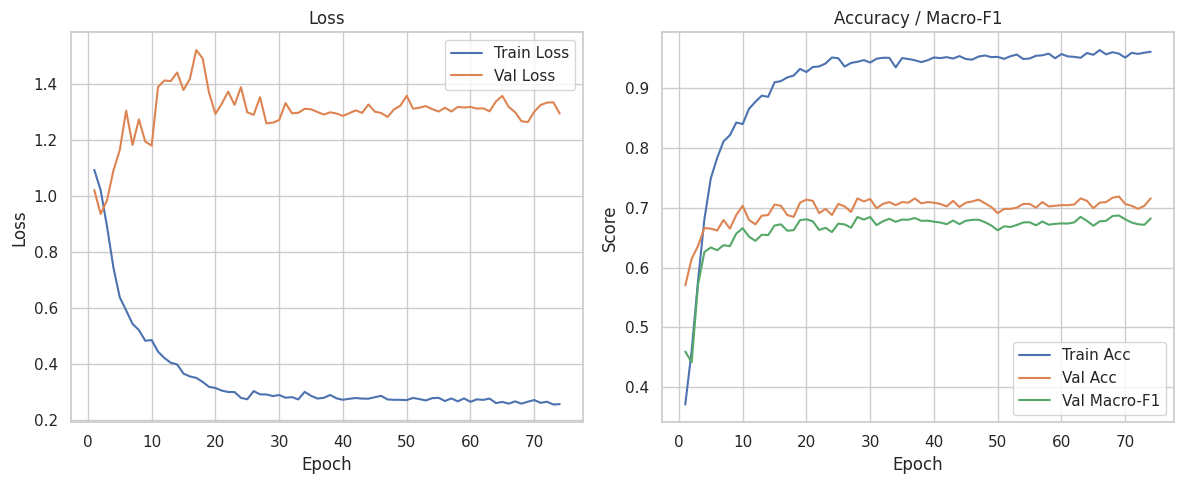

In [ ]:
# Plot training curves (if available)
if 'history' in globals() and history is not None:
    plot_results(history)
else:
    print("No training history found. Train the model first (train=True) or load a checkpoint with history.")


# PART FOUR

---

# Part 4 — Detailed Evaluation on the Validation Set

In this section we evaluate the trained model on the **validation** split using standard classification metrics.
Because the task is **3-class** (Negative / Neutral / Positive) and the dataset is **imbalanced**, we report more than accuracy.

**Goal:** compute and report:
- Accuracy
- Precision
- Recall
- F1-score  
and visualize a **Confusion Matrix** with proper class labels.

---

## 4.1 Classification Metrics

### Metrics reported
For the full validation set, we compute:

- **Accuracy**
  $
  \text{Accuracy} = \frac{\#\text{correct predictions}}{\#\text{total samples}}
  $

- **Precision**
  $
  \text{Precision} = \frac{TP}{TP + FP}
  $

- **Recall**
  $
  \text{Recall} = \frac{TP}{TP + FN}
  $

- **F1-score**
  $
  F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $

### Averaging method
Because this is **multi-class**, we must choose an averaging strategy:

- **Macro average**: average of per-class scores (treats classes equally)
  - best for imbalanced datasets when you care about minority classes

- **Weighted average**: weighted by class support (majority class has more influence)

We have achieved about 0.7 macro-F1.

### Expected output
A printed report containing:
- Accuracy
- Precision (macro or weighted)
- Recall (macro or weighted)
- F1-score (macro or weighted)

---

## 4.2 Confusion Matrix Visualization

### What it shows
A confusion matrix displays how predictions are distributed across true classes:

- Rows = true labels
- Columns = predicted labels

This helps identify:
- which classes are confused (e.g., Positive vs Neutral)
- whether the model collapses to Neutral due to imbalance
- systematic errors in the classifier

### Required labels
The axes must be labeled clearly with:
- **Negative**
- **Neutral**
- **Positive**

### Expected output
- A numeric confusion matrix
- A plotted heatmap-style visualization with labeled axes

---

## Notes & Common Pitfalls

- **Imbalance effect:** high accuracy can hide poor performance on Positive/Negative.
- **Macro vs weighted:** always state which averaging method you used.
- **Use `model.eval()` + `torch.no_grad()`** during evaluation.
- Ensure correct mapping between label indices and class names:
  - `0 → Negative`, `1 → Neutral`, `2 → Positive` (or your chosen mapping)

---

 After finishing Part 4, we have:
- a full metric report (including macro-F1)
- a labeled confusion matrix plot
- insight into which classes the model struggles with most

Evaluation on Validation Set
Accuracy:  0.7392
Precision (weighted): 0.7405
Recall (weighted):    0.7392
F1-score (weighted):  0.7398

Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.66      0.64       121
     neutral       0.81      0.80      0.81       576
    positive       0.64      0.64      0.64       273

    accuracy                           0.74       970
   macro avg       0.69      0.70      0.70       970
weighted avg       0.74      0.74      0.74       970



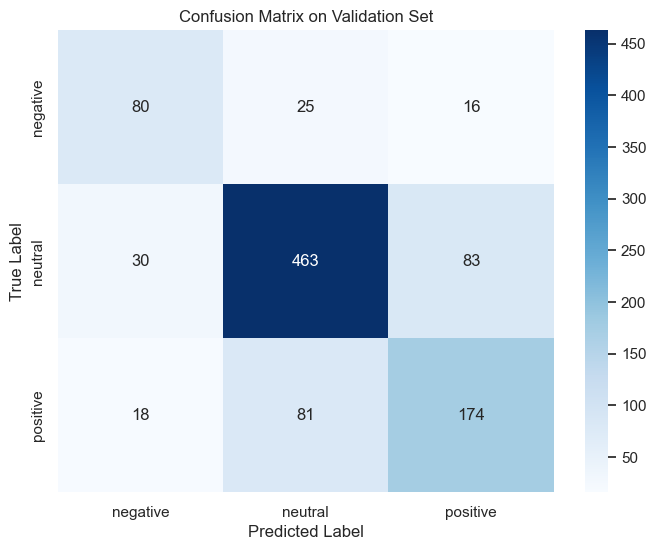


Per-class metrics:
negative   | Precision: 0.6250 | Recall: 0.6612 | F1: 0.6426
neutral    | Precision: 0.8137 | Recall: 0.8038 | F1: 0.8087
positive   | Precision: 0.6374 | Recall: 0.6374 | F1: 0.6374


In [42]:
# PART FOUR: Evaluation on Validation Set
# ----------------------------------------
# This part computes standard classification metrics and confusion matrix
# to evaluate the final model performance on the validation data.

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []
all_probs = []   # optional: store probabilities if needed

# Disable gradient computation for efficiency
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)          # logits, shape (batch_size, num_classes)
        probs = torch.softmax(outputs, dim=1)               # probabilities (optional)
        preds = torch.argmax(outputs, dim=1)                # predicted class indices

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays for sklearn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("Evaluation on Validation Set")
print("============================")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted):    {recall:.4f}")
print(f"F1-score (weighted):  {f1:.4f}")

# Detailed classification report (per class)
target_names = ['negative', 'neutral', 'positive']   # as defined earlier
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Optional: per-class metrics if needed
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
print("\nPer-class metrics:")
for i, name in enumerate(target_names):
    print(f"{name:10} | Precision: {precision_per_class[i]:.4f} | Recall: {recall_per_class[i]:.4f} | F1: {f1_per_class[i]:.4f}")

<font color=3C99D size=5>
Conclusion: </font>

We consider macro F1 more as weighted F1 hides imbalance while macro F1 exposes it.



# PART FIVE

---

# Part 5 — Evaluate on the Test Set & Generate Submission File

In this section we run the trained model on the **unlabeled test set** (provided separately by the course/judge) and generate a `.csv` file containing model predictions.

**Goal:** produce a submission-ready CSV file with one prediction per test sentence.

---

## 5.1 Test-Time Inference

### What we do
1. Load the test data file (sentences only, **no labels**).
2. Apply the same preprocessing and tokenization used during training:
   - BERT tokenizer
   - fixed `MAX_LEN`
   - `input_ids` and `attention_mask`
3. Set model to evaluation mode:
   - `model.eval()`
   - use `torch.no_grad()` to disable gradients
4. Run forward passes and convert logits to predicted labels:
   \[
   \hat{y} = \arg\max(\text{logits})
   \]

### Expected output
A list/array of predicted class indices for all test samples.

---

## 5.2 Create the Submission CSV

### What we do
- Store predictions in a DataFrame.
- Convert label indices to label names if required by the competition format.
- Save as a CSV file (e.g., `submission.csv`).

**Typical formats**
Depending on the judge, submissions are commonly one of these:

**Format A (index + label):**
- `id`, `label`

**Format B (sentence + label):**
- `sentence`, `label`

Your notebook should follow **exactly** the format required by the evaluation system.

### Expected output
- A saved CSV file (e.g., `submission.csv`)
- A preview of the first few rows to verify correctness

---

## Notes & Common Pitfalls

- **Do not shuffle** test data loader if the judge expects original order.
- Make sure the label mapping matches training:
  - `0 → Negative`, `1 → Neutral`, `2 → Positive` (or your mapping)
- Use the same `MAX_LEN`, tokenizer, and preprocessing as training.
- Ensure the CSV contains **only** the required columns and no extra index column (unless required).

---

 After finishing Part 5, we have:
- predictions for the unseen test set
- a correctly formatted `submission.csv` file ready to upload to the judging system

In [44]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1. Load the test data
test_df = pd.read_csv('sentences.csv')

# 2. Prepare the Test DataLoader 
# Ensure shuffle=False so the predictions match the row_id order
import numpy as np
import pandas as pd

# 1. Keep as Pandas Series (this provides the .values attribute the class wants)
test_sentences = test_df['sentence'] 
dummy_labels = pd.Series(np.zeros(len(test_df)))
dummy_weights = pd.Series(np.ones(len(test_df)))

# 2. Pass them into the constructor
# We removed .tolist() so the class gets the Series it expects
test_dataset = FinancialDataset(
    sentences=test_sentences, 
    labels=dummy_labels, 
    weights=dummy_weights,
    tokenizer=tokenizer, 
    max_len=80
)

# 3. Proceed with the DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Proceed with the DataLoader as before
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
all_test_preds = []

# 3. Inference Loop
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        all_test_preds.extend(preds)

# 4. Format for Submission
# Convert numeric predictions back to string labels (positive, negative, neutral)
final_labels = label_encoder.inverse_transform(all_test_preds)

# Create the submission DataFrame with required columns
submission_df = pd.DataFrame({
    'row_id': range(len(final_labels)),
    'label': final_labels
})

# 5. Save to CSV
submission_df.to_csv('submission.csv', index=False)

print(f"Successfully saved {len(submission_df)} predictions to 'submission.csv'")
print(submission_df.head())

Predicting on test set: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Successfully saved 300 predictions to 'submission.csv'
   row_id     label
0       0  positive
1       1  negative
2       2  negative
3       3   neutral
4       4  negative


# PART SIX

---

# Part 6 — Visual Output of the Attention Mechanism (15 points)

This section visualizes what the Transformer attends to by extracting and plotting **attention weights** from the **last Transformer layer**.

**Goal:** for at least **5 test sentences**, extract the attention weight matrix and plot it as a **heatmap** to interpret which tokens receive the most attention.

---

## 6.1 Why Attention Visualization?

Self-attention computes how strongly each token attends to other tokens:

$
A = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
$

Where:
- \(A\) is the attention weight matrix of shape \((T \times T)\)
- \(T\) is the sequence length (after padding/truncation)

A heatmap of \(A\) helps us see:
- which words influence the model’s decision most
- whether sentiment-bearing terms (e.g., *profit*, *loss*, *upgrade*) receive high attention
- patterns like focusing on numbers, negations, or company-specific keywords

---

## 6.2 What We Extract

From the **last layer** of the model:
- attention weights per head: `(num_heads, T, T)`
- optionally averaged across heads: `(T, T)`

We typically visualize either:
- a single head (easier to interpret sometimes), or
- the **mean across heads** (more stable, less noisy)

 For interpretability, averaging across heads is often recommended:
$
A_{\text{avg}} = \frac{1}{H}\sum_{h=1}^{H} A_h
$

---

## 6.3 Heatmap Visualization (Required)

### What we do
For each of the first **5 test sentences**:
1. Tokenize the sentence (`input_ids`, `attention_mask`)
2. Run a forward pass while storing attention weights
3. Convert token IDs back to readable tokens
4. Select the valid tokens (exclude padding)
5. Plot a heatmap where:
   - x-axis = tokens being attended **to**
   - y-axis = tokens attending **from**
   - values = attention weights

### Required labels
The heatmap axes should show the token strings clearly.  
(If tokens are subwords like `##ing`, that is normal for BERT tokenizers.)

---

## Notes & Common Pitfalls

- **Padding:** Always remove padded positions before plotting (otherwise heatmap is dominated by PAD).
- **Model mode:** use `model.eval()` and `torch.no_grad()` for visualization runs.
- **Storage:** attention weights should be stored only when needed (to avoid slowing training).
- **Token limits:** long sentences are truncated to `MAX_LEN`, so the heatmap covers only the first `MAX_LEN` tokens.



In [48]:
# Select the first 5 test sentences
num_samples = 5
test_sentences_list = test_df['sentence'].iloc[:num_samples].values

model.eval()
# CRITICAL: Ensure the model is told to store weights
model.set_store_attention(True) 

test_attention_matrices = []
test_valid_lengths = []

with torch.no_grad():
    for sent in test_sentences_list:
        encoding = tokenizer(
            sent,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(device)

        # Forward pass
        _ = model(encoding['input_ids'], encoding['attention_mask'])

        # Capture the weights
        attn_weights = model.layers[-1].attention.last_attention_weights 
        
        if attn_weights is not None:
            # Average across heads, move to CPU
            avg_attn = attn_weights.mean(dim=1).squeeze(0).cpu().numpy()
            test_attention_matrices.append(avg_attn)
            
            valid_len = int(encoding['attention_mask'].squeeze(0).sum().item())
            test_valid_lengths.append(valid_len)
        else:
            print("Warning: Attention weights were not captured for this sentence.")

# Clean up
model.set_store_attention(False)

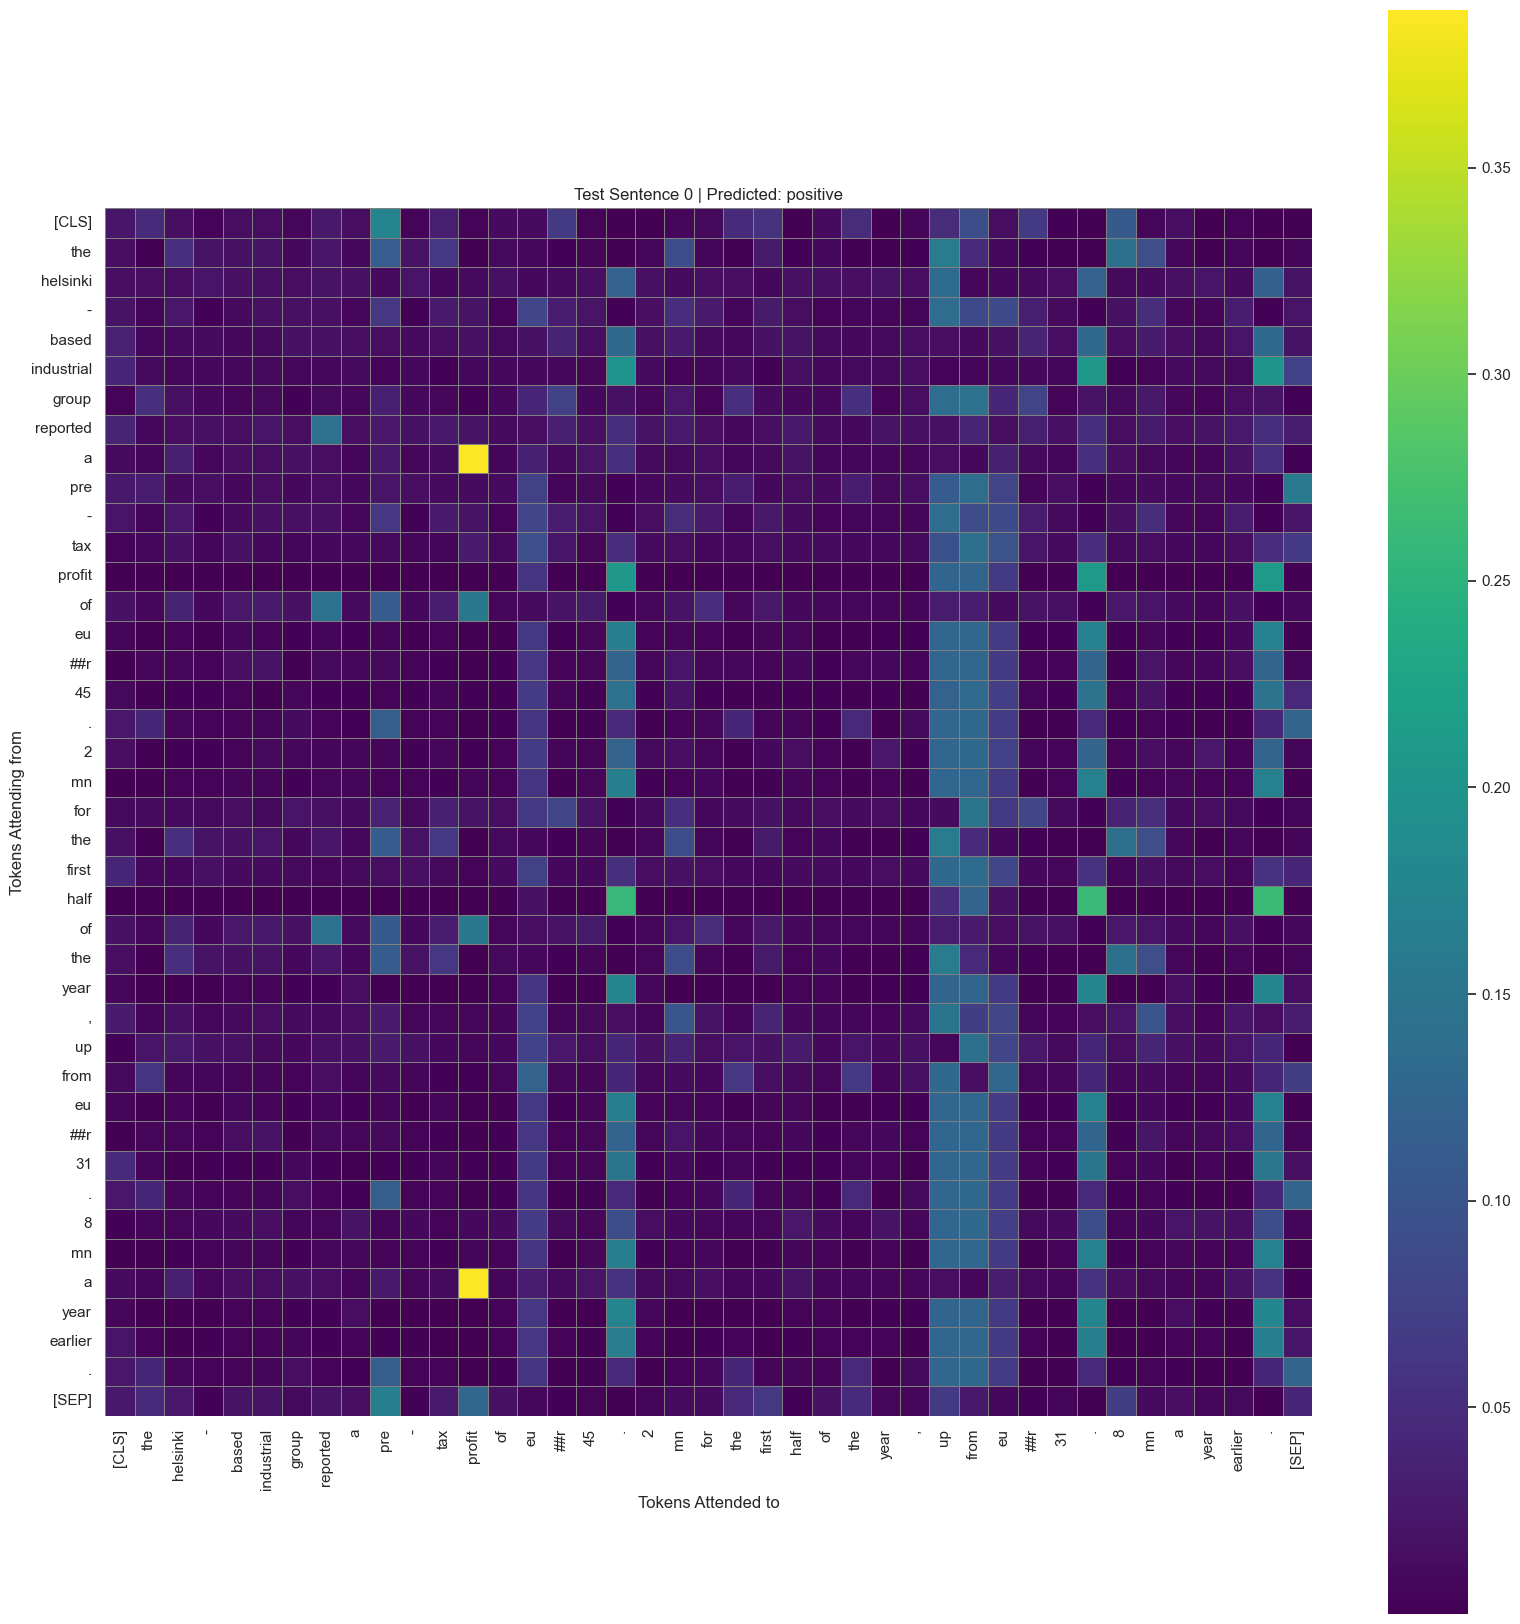

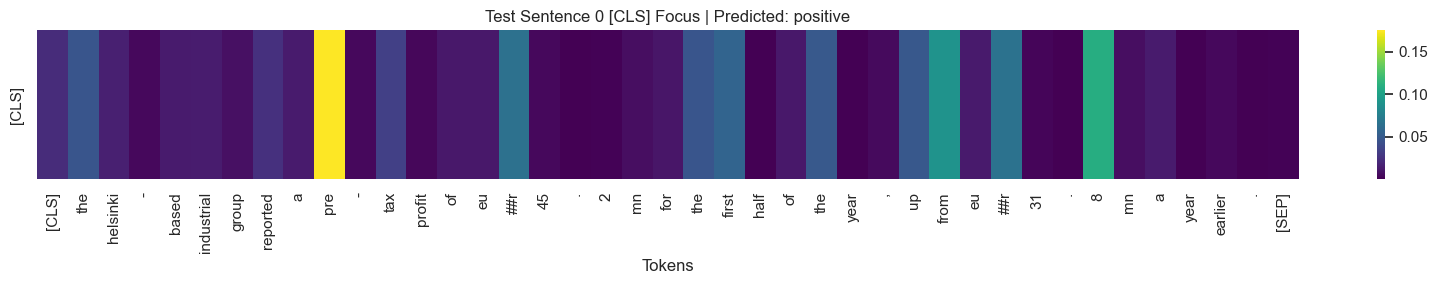

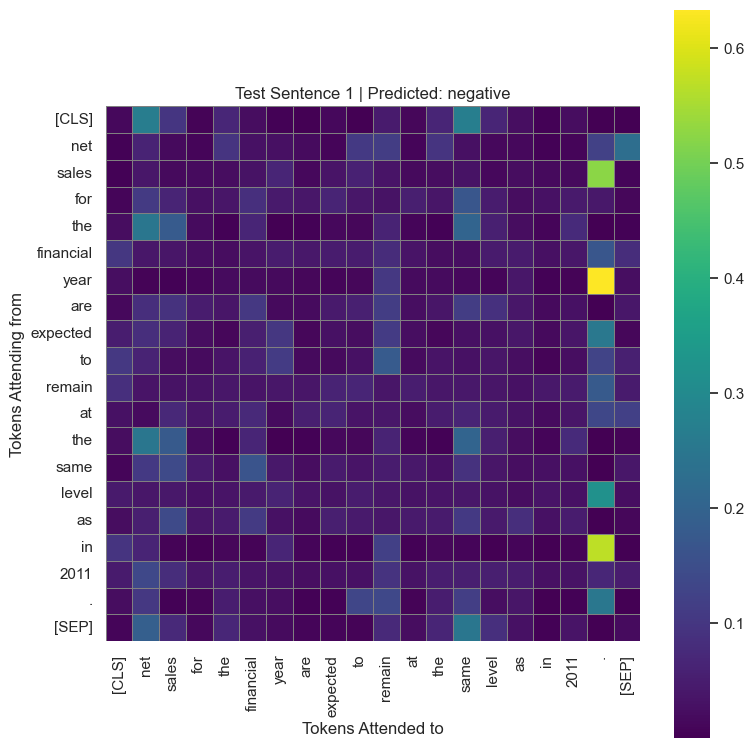

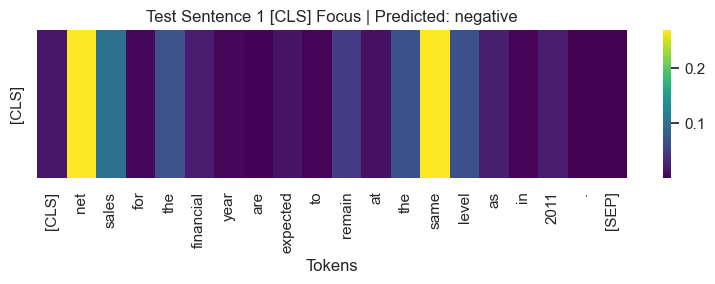

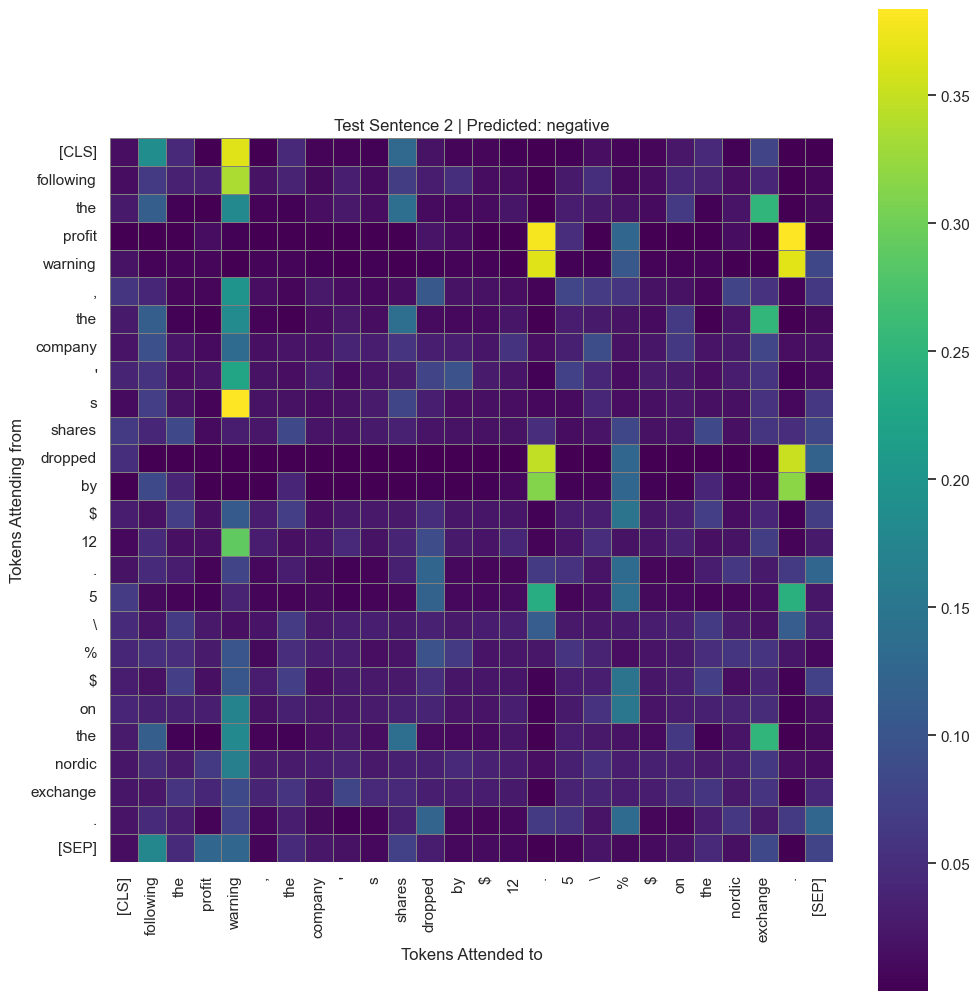

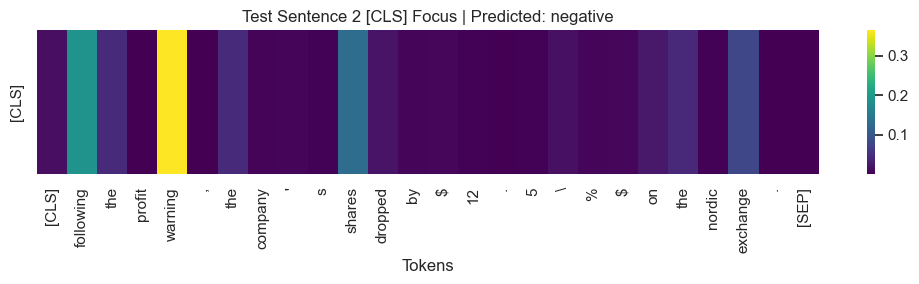

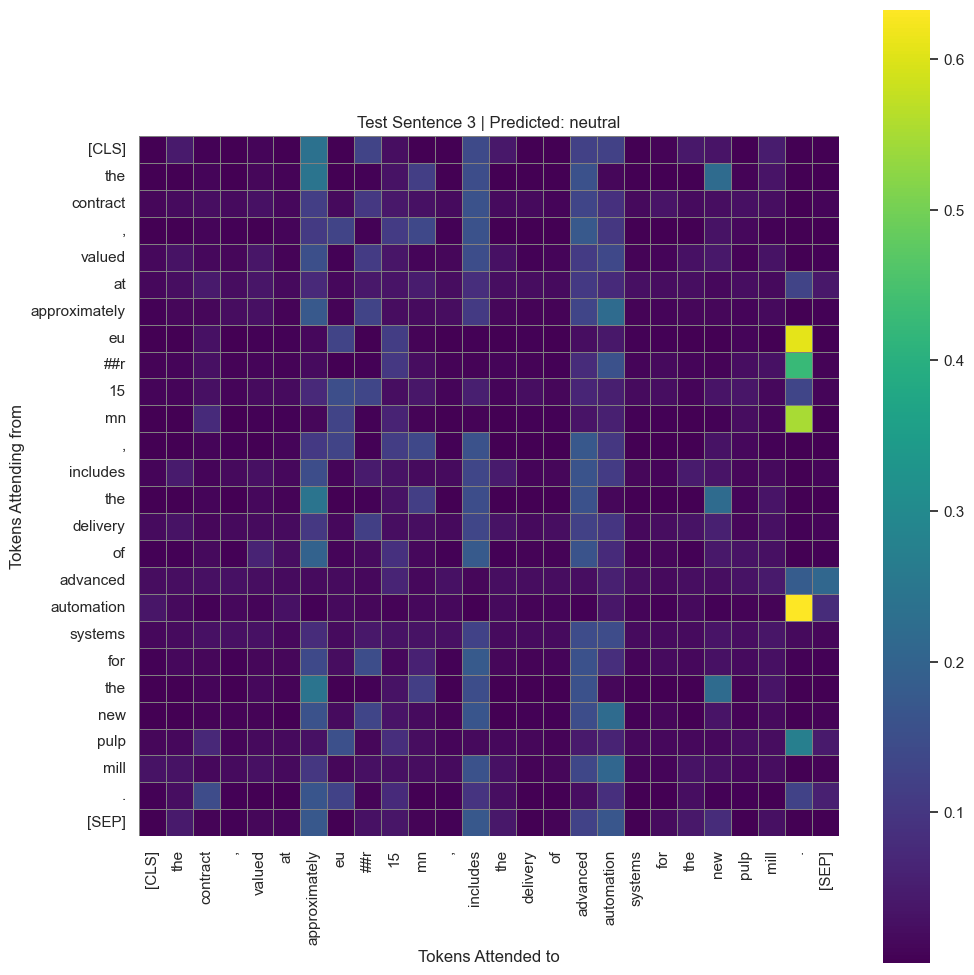

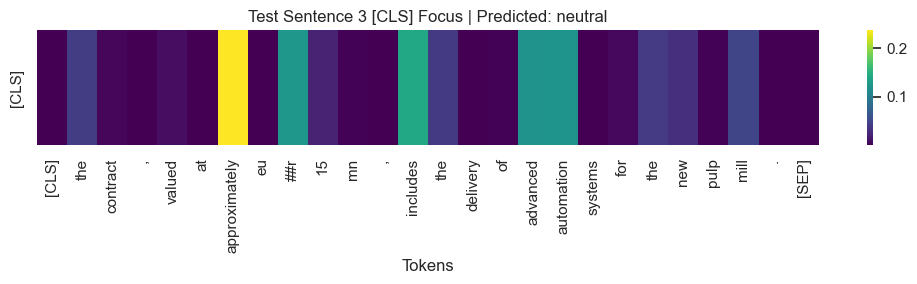

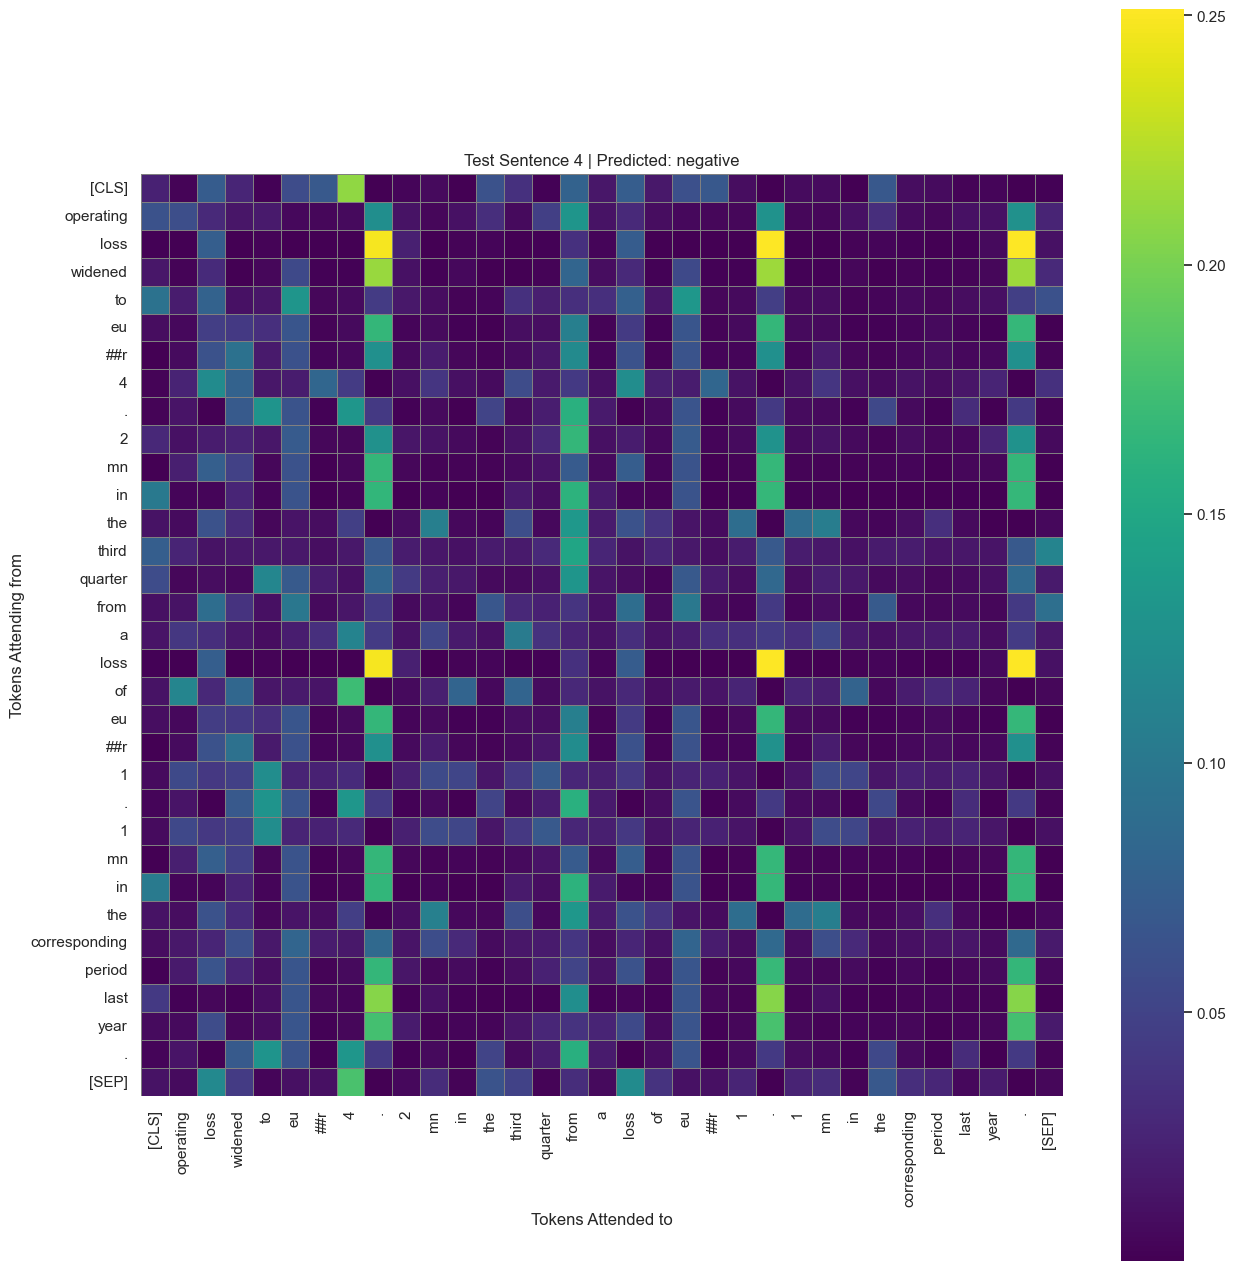

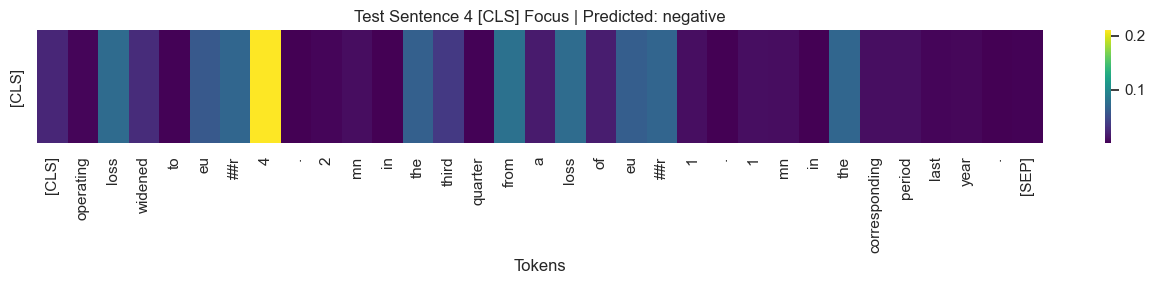

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through the extracted test data
for i in range(num_samples):
    sent = test_sentences[i]
    attn_matrix = test_attention_matrices[i]
    valid_len = test_valid_lengths[i]
    
    # Get the predicted label for this specific test row
    pred_label = submission_df.iloc[i]['label']

    # 1. Reconstruct tokens exactly as the tokenizer saw them
    # We use encode then convert to ensure special tokens [CLS]/[SEP] are present
    tokens = tokenizer.convert_ids_to_tokens(
        tokenizer.encode(sent, max_length=MAX_LEN, truncation=True)
    )

    # 2. Slice the attention matrix and tokens to remove padding [PAD]
    # This ensures the heatmap only shows actual words
    attn_matrix_clean = attn_matrix[:valid_len, :valid_len]
    tokens_clean = tokens[:valid_len]

    # 3. Plot the full Attention Matrix (Word-to-Word relationships)
    figsize = max(8, min(20, valid_len * 0.4))
    plt.figure(figsize=(figsize, figsize))
    
    sns.heatmap(
        attn_matrix_clean, 
        xticklabels=tokens_clean, 
        yticklabels=tokens_clean,
        cmap='viridis', 
        cbar=True, 
        square=True,
        linewidths=0.5, 
        linecolor='gray'
    )

    plt.title(f"Test Sentence {i} | Predicted: {pred_label}")
    plt.xlabel("Tokens Attended to")
    plt.ylabel("Tokens Attending from")
    plt.tight_layout()
    plt.show()

    # 4. Plot the [CLS] Token Attention (What the model focused on for classification)
    # The [CLS] token is at index 0 and represents the aggregate sentiment
    cls_attention = attn_matrix_clean[0] 

    plt.figure(figsize=(figsize, 3))
    sns.heatmap(
        cls_attention.reshape(1, -1),
        xticklabels=tokens_clean,
        yticklabels=["[CLS]"],
        cmap="viridis",
        cbar=True
    )

    plt.title(f"Test Sentence {i} [CLS] Focus | Predicted: {pred_label}")
    plt.xlabel("Tokens")
    plt.tight_layout()
    plt.show()